## Import Libs + Functions

In [21]:
## Import functions for Data Scraping, Treatment and Plotting

## System
import re
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

## EDA
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
pd.set_option('display.max_columns', None)


## Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

## Statistics
from scipy.stats import f_oneway
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from scipy.stats import zscore

from scipy.stats import shapiro
from scipy.stats import normaltest

import scikit_posthocs as sp 
from statsmodels.graphics.gofplots import qqplot


In [22]:
##----------------------BASE FUNCTIONS FOR READING CSV AND FILTERING DATA

## IMPORT DATA FROM CSV FILE
def ImportData(team_file, type):
    folder = team_file + '/'
    maps_file = team_file + '_'+type+'_MAPS.csv'
    matches_file = team_file + '_'+type+'_MATCHES.csv'
    
    maps = pd.read_csv(CSV_PATH + folder + maps_file)
    matches = pd.read_csv(CSV_PATH + folder + matches_file)

    return maps, matches

## FILTER DATAFRAME BY GIVEN COLUMN ON GIVEN VALUE
def FilterCol(df, col, values):
    return df[df[col].isin(values)].reset_index(drop=True)

def BinaryTarget(variavel, quantil):
  bin = (variavel > variavel.quantile(q = quantil)).astype(int)
  return bin

##----------------------IMPORT + FILTERING DATA

## Aggregate base_geral by (Team, Match, Map)
def aggBase(base_geral):
    
    mean_agg_cols  = ['ACS', 'K',	'D',	'A',	'KD_DIFF',	'ADR',	'HS%', 'ECON']
    
    sum_agg_cols   = ['FK',	'FD', 'KPR',	'DPR',	'APR',	'FKPR'	,'FDPR',	
                        '2K'	,'3K',	'4K'	,'5K',	
                        '1v1','1v2',	'1v3'	,'1v4'	,'1v5' ,'PL',	'DE', 
                        'total_mult_kill', 'MKPR', 'total_clutch' ,'CPR'] + AGENTS
    
    first_agg_cols = ['Opp_Team_x', 'rounds_won'	,'rounds_lost', 'ct_rounds_won','ct_rounds_lost','t_rounds_won','t_rounds_lost' ,	
                        'Patch_x'	,'total_rounds', 'win_rate', 'ct_wr' , 't_wr', 'RESULT']

    
    '''['Pistol_W','Pistol_P','Pistol_WR' ,'Eco_0_5_P','Eco_0_5_W','Eco_0_5_WR' ,
    'Semi_Eco_5_10_P', 'Semi_Eco_5_10_W','Semi_Eco_5_10_WR', 
    'Semi_Buy_10_20_P','Semi_Buy_10_20_W','Semi_Buy_10_20_WR',
    'Full_Buy_20_P'	,'Full_Buy_20_W','Full_Buy_20_WR']'''

    agg_first = base_geral.groupby(['Team_x','match_id','Map']).first()[first_agg_cols].reset_index()
    agg_sum = base_geral.groupby(['Team_x','match_id','Map']).sum()[sum_agg_cols].reset_index()
    agg_mean = base_geral.groupby(['Team_x','match_id','Map']).mean()[mean_agg_cols].reset_index().round(2)

    merge_agg = agg_mean.merge(agg_sum, how='inner', left_on=['Team_x','match_id','Map'],right_on=['Team_x','match_id','Map']).drop_duplicates()
    merge_agg = merge_agg.merge(agg_first, how='inner', left_on=['Team_x','match_id','Map'],right_on=['Team_x','match_id','Map']).drop_duplicates()

    #merge_agg = merge_agg.merge(economy_maps, how='inner', left_on=['match_id','Map','Team_x'],right_on=['match_id','Map','Team']).drop_duplicates()

    return merge_agg
    

## Get Map data for all teams
def AllTeamsMaps(files, type, team_col, filter_teams):
    concat = pd.concat([ImportData(team_file, type)[0] for team_file in files])
    filter = FilterCol(concat, team_col, filter_teams)
    filter = concat

    filter[team_col][(filter[team_col] == 'NOOR') | (filter[team_col] == 'NOORG2.0')] = 'paiN'
    filter[team_col][filter[team_col] == 'Mix'] = 'IMP'
    filter[team_col][(filter[team_col] == 'Ingaming') | (filter[team_col] == 'NMDM')] = 'Inga'
    filter[team_col][filter[team_col] == 'FF'] = 'VORA'
    filter[team_col][filter[team_col] == 'HAVA'] = 'HAVAN'
    filter[team_col][filter[team_col] == 'FURI'] = 'FURIA'
    filter[team_col][(filter[team_col] == 'S5') | (filter[team_col] == 'Shar')] = 'Sharks'
    
    
    if type == 'overview': ExtraInfoMaps(filter)
    if type == 'performance':
        # total mult kill + mult kills per round
        filter['total_mult_kill'] = filter.loc[: ,['2K','3K','4K','5K']].sum(axis=1)	

        # total clutches + clutches per round
        filter['total_clutch'] = filter.loc[: ,['1v1','1v2','1v3','1v4','1v5']].sum(axis=1)
    return filter

## Get Match data for all teams
def AllTeamsMatches(files, type, team_col, filter_value):
    concat = pd.concat([ImportData(team_file, type)[1] for team_file in files])
    filter = FilterCol(concat, team_col, filter_value)
    
    filter[team_col][(filter[team_col] == 'NOOR') | (filter[team_col] == 'NOORG2.0')] = 'paiN'
    filter[team_col][filter[team_col] == 'Mix'] = 'IMP'
    filter[team_col][(filter[team_col] == 'Ingaming') | (filter[team_col] == 'NMDM')] = 'Inga'
    filter[team_col][filter[team_col] == 'FF'] = 'VORA'
    filter[team_col][filter[team_col] == 'HAVA'] = 'HAVAN'
    filter[team_col][filter[team_col] == 'FURI'] = 'FURIA'
    filter[team_col][(filter[team_col] == 'S5') | (filter[team_col] == 'Shar')] = 'Sharks'
    
    if type == 'overview': ExtraInfoMatches(filter)
    return filter


## ADD EXTRA INFO TO MATCHES DATAFRAME -- OVERVIEW
def ExtraInfoMatches(df):
    # KDA + FK/FD per map
    df['KPM'] = round(df['K'] / df['Num_maps'],2)
    df['DPM'] = round(df['D'] / df['Num_maps'],2)
    df['APM'] = round(df['A'] / df['Num_maps'],2)
    df['FKPM'] = round(df['FK'] / df['Num_maps'],2)
    df['FDPM'] = round(df['FD'] / df['Num_maps'],2)

## CLUTCH TOTAL, CLUTCH PER ROUND, MULT KILL TOTAL, MULT KILL PER ROUND

## ADD EXTRA INFO TO MAPS DATAFRAME -- OVERVIEW
def ExtraInfoMaps(df):

    # Total Rounds
    df['total_rounds'] = df['rounds_won'] + df['rounds_lost']

    # Round Win Rate
    df['win_rate'] = round(df['rounds_won'] / df['total_rounds'] * 100, 2)

    # KDA + FK/FD per Round
    df['KPR'] = round(df['K'] / df['total_rounds'],2)
    df['DPR'] = round(df['D'] / df['total_rounds'],2)
    df['APR'] = round(df['A'] / df['total_rounds'],2)
    df['FKPR'] = round(df['FK'] / df['total_rounds'],2)
    df['FKWR'] = round(100 * df['FK'] / (df['FK'] + df['FD']), 2)
    df['FDPR'] = round(df['FD'] / df['total_rounds'],2)

    # ATK/DEF Win rate -- ct_rounds_won	ct_rounds_lost	t_rounds_won	t_rounds_lost
    df['ct_wr'] = round(100 * df['ct_rounds_won'] / (df['ct_rounds_won'] + df['ct_rounds_lost']), 2)
    df['t_wr'] = round(100 * df['t_rounds_won'] / (df['t_rounds_won'] + df['t_rounds_lost']), 2)


    # Won/Lost Map 
    df['RESULT'] = ['W' if x == True
                    else 'L'
                    for x in df['rounds_won'] > df['rounds_lost']]

## One Hot Encoding Categorical Cols
def GetDummies(df, cat_cols):

    for col in cat_cols:
        one_hot = pd.get_dummies(df[col])
        #df.drop(col, axis=1, inplace=True)
        df = pd.concat([df, one_hot], axis=1)
    return df

##----------------------STATS FUNCS

## CORRELATION OF GIVEN FEATURE WITH NUMBER OF ROUNDS WON
'''def WinCorr(df, stats, filter_maps = None):
    if filter_maps is not None:
        df = FilterMap(df, filter_maps)
    group = maps.groupby('rounds_won').mean()[stats].reset_index()
    corr_pearson = (group.corr())['rounds_won'][stats]
    corr_spearman = (group.corr(method='spearman'))['rounds_won'][stats]
    corr_kendall = (group.corr(method='kendall'))['rounds_won'][stats]
    print("Correlação Pearson média({0}) por Rounds Vencidos:\n{1}".format(stats, round(corr_pearson, 4)))
    print("Correlação Spearman média({0}) por Rounds Vencidos:\n{1}".format(stats, round(corr_spearman, 4)))
    print("Correlação Kendall média({0}) por Rounds Vencidos:\n{1}".format(stats, round(corr_kendall, 4)))

## CORRELATION OF GIVEN FEATURE WITH NUMBER OF ROUNDS WIN RATE
def WinRateCorr(df, stats, filter_maps = None):
    if filter_maps is not None:
        df = FilterCol(df, 'Map', filter_maps)
    group = df.groupby('win_rate').mean()[stats].reset_index()
    corr_pearson = (group.corr())['win_rate'][stats]
    corr_spearman = (group.corr(method='spearman'))['win_rate'][stats]
    corr_kendall = (group.corr(method='kendall'))['win_rate'][stats]
    print("Correlação Pearson média({0}) por Win Rate:\n{1}".format(stats, round(corr_pearson, 4)))
    print("Correlação Spearman média({0}) por Win Rate:\n{1}".format(stats, round(corr_spearman, 4)))
    print("Correlação Kendall média({0}) por Win Rate:\n{1}".format(stats, round(corr_kendall, 4)))'''

def CheckGaussian(x):
    #s, p = normaltest(x)
    s, p = shapiro(x)
    print('Test Stat=%.3f, p-value:%.6f' % (s, p))
    alpha = 0.05
    if p < alpha:
        print('Sample does not look Gaussian (reject H0)')
    else:
        print('Sample looks Gaussian (fail to reject H0)') 

def AnovaOneWay(df, name_col, value_col):
    lista_grupos = []
    for x in name_col.unique():
        lista_grupos.append(df.loc[name_col == x, value_col])
    stat, p = f_oneway(*lista_grupos)
    print('--Testes com %d grupos--' % len(name_col.unique()))
    print('--Estatística do teste = %.3f, p-valor = %.10f' % (stat, p))

    if p > 0.05:
        print('Não há evidências estatísticas significativas para concluir que existe diferença entre as medianas dos grupos')
    else:
        print('Há evidências estatísticas significativas que indicam diferença entre as medianas dos grupos')

def KruskalWallis(df, name_col, value_col):
    lista_grupos = []
    for x in name_col.unique():
        lista_grupos.append(df.loc[name_col == x, value_col])
    stat, p = kruskal(*lista_grupos)
    print('--Testes com %d grupos--' % len(name_col.unique()))
    print('--Estatística do teste = %.3f, p-valor = %.10f' % (stat, p))

    if p > 0.05:
        print('Não há evidências estatísticas significativas para concluir que existe diferença entre as medianas dos grupos')
    else:
        print('Há evidências estatísticas significativas que indicam diferença entre as medianas dos grupos')

def DunnPostHoc(df, name_col, value_col):
    lista_grupos = []
    for x in name_col.unique():
        lista_grupos.append(df.loc[name_col == x, value_col])
    ph_dunn = sp.posthoc_dunn(lista_grupos)
    print(ph_dunn)
    cmap = ['1', '#fb6a4a',  '#08306b',  '#4292c6', '#c6dbef']
    heatmap_args = {'cmap': cmap, 'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
    sp.sign_plot(ph_dunn, **heatmap_args)

def QuantileCut(df, nome_col, value_col, quantis=5):
    if quantis > 0:
        quantiles = pd.qcut(x=df[nome_col], q=quantis)
    else:
        quantiles = df[nome_col]
    sns.set(rc={'figure.figsize':(12,7)})
    sns.boxplot(x=quantiles, y=df[value_col])
    return quantiles

def CorrMatrixWinRate(df, cols):
    cols = cols + ['win_rate']
    corr_spearman = round(df[cols].corr(method='pearson'),3)
    mask = np.zeros_like(corr_spearman)
    mask[np.triu_indices_from(mask)] = True
    sns.set(rc={'figure.figsize':(12,7)})
    sns.heatmap(corr_spearman,  fmt="f", vmin=0, vmax=1, mask=mask, annot=True)

def PlotCorr(df, nome_col, value_col):
    df_util = df.loc[~df[nome_col].isna()]
    corr_pearson = (df_util.corr())[value_col][nome_col]
    corr_spearman = (df_util.corr(method='spearman'))[value_col][nome_col]
    corr_kendall = (df_util.corr(method='kendall'))[value_col][nome_col]
    print("Correlação Pearson {0} por Win Rate: {1}".format(nome_col, round(corr_pearson, 4)))
    print("Correlação Spearman {0} por Win Rate: {1}".format(nome_col, round(corr_spearman, 4)))
    print("Correlação Kendall {0} por Win Rate: {1}".format(nome_col, round(corr_kendall, 4)))
    #print('Correlação linear: ' + str(np.corrcoef(df_util[value_col], df_util[nome_col])[0, 1]))
    sns.set(rc={'figure.figsize':(12,7)})
    sns.scatterplot(x=df_util[nome_col], y=df_util[value_col])



##----------------------PLOT FUNCS

def Boxplot(df, nome_col, value, title):
    sns.set(rc={'figure.figsize':(12,7)})
    sns.boxplot(x=df[nome_col], y=df[value], order=df[nome_col].sort_values().unique()).set_title(title)

def HistbyCol(df ,value_col, filter):
    sns.set(rc={'figure.figsize':(12,7)})
    sns.displot(data=df, x=value_col, col=filter)

def PlotAgentPickRate(df):
    for i, map in enumerate(MAPS):
        filter = FilterCol(df, 'Map', [map])
        agent_pick_rate = filter['Agents'].value_counts() / (len(filter) / 5)  * 100
        plt.figure(i, figsize=(10,7))
        sns.barplot(y=agent_pick_rate.index, x=agent_pick_rate.values, palette="Blues_d").set_title('Agent Pick Rate -- '+map+' -- Played: '+str(int(len(filter) / 5))+' times')

---
## Global Vars + Import Data + Combine Data

In [3]:
ALL_FILES = ['gamelanders', 'pain', 'vorax', 'havan', 'imperial', 'ingaming', 'vikings', 'black_dragons', 'furia', 'rise', 'slick', 'sharks']
ALL_TEAMS = ['GL', 'IMP','Mix', 'HAVAN', 'HAVA', 'Inga', 'Ingaming', 'NMDM', 'VKS', 'FF', 'VORA', 'BD', 'paiN','NOOR', 'NOORG2.0', 
                'S5', 'Sharks', 'Shar', 'FURI', 'FURIA', 'Rise', 'SLK']

MAPS = ['ASCENT', 'BIND', 'HAVEN', 'ICEBOX', 'SPLIT']

DUELIST = ['jett', 'raze', 'phoenix','reyna', 'yoru']
CONTROLLER = ['omen', 'brimstone', 'viper', 'astra'] 
SENTINEL = ['cypher', 'sage', 'killjoy'] 
INITIATOR = ['breach', 'sova', 'skye']
AGENTS = DUELIST + CONTROLLER + SENTINEL + INITIATOR

CSV_PATH = '../data/csv/'
EXCEL_PATH = '../data/excel/'

In [18]:
overview_maps = AllTeamsMaps(ALL_FILES, 'overview', 'Team', ALL_TEAMS)
performance_maps = AllTeamsMaps(ALL_FILES, 'performance', 'Team', ALL_TEAMS)
economy_maps = AllTeamsMaps(ALL_FILES, 'economy', 'Team', ALL_TEAMS)

In [32]:
performance_maps.head(10)

Player  2K  3K   4K   5K  1v1  1v2  1v3  1v4  1v5  ECON  PL  DE  \
0      Nyang   1   1  0.0  0.0  0.0  1.0  0.0  0.0  0.0    30   0   1   
1      fznnn   3   0  0.0  0.0  0.0  1.0  0.0  0.0  0.0    31   0   0   
2       JhoW   3   0  0.0  0.0  2.0  0.0  0.0  0.0  0.0    38   3   0   
3       Jonn   6   1  1.0  0.0  0.0  1.0  0.0  0.0  0.0   115   0   0   
4     mwzera   3   1  0.0  0.0  0.0  0.0  0.0  0.0  0.0    74   0   0   
5        rst   0   0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    35   3   0   
6    Evilkyk   2   0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    33   0   0   
7       tuyz   3   1  0.0  0.0  0.0  0.0  0.0  0.0  0.0    68   0   0   
8  Biscoit1n   2   0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    54   0   0   
9      txddy   1   2  0.0  0.0  0.0  0.0  0.0  0.0  0.0    53   0   0   

   match_id Team Opp_Team    Map  Patch  total_mult_kill  total_clutch  
0      6797   GL      IMP  SPLIT   1.12              2.0           1.0  
1      6797   GL      IMP  SPLIT   1.12              3.0           1.0  
2      6797   GL      IMP  SPLIT   1.12              3.0           2.0  
3      6797   GL      IMP  SPLIT   1.12              8.0           1.0  
4      6797   GL      IMP  SPLIT   1.12              4.0           0.0  
5      6797  IMP       GL  SPLIT   1.12              0.0           0.0  
6      6797  IMP       GL  SPLIT   1.12              2.0           0.0  
7      6797  IMP       GL  SPLIT   1.12              4.0           0.0  
8      6797  IMP       GL  SPLIT   1.12              2.0           0.0  
9      6797  IMP       GL  SPLIT   1.12              3.0           0.0

In [19]:
## Merge Overview + Performance + Economy into Base Geral
base_geral = overview_maps.merge(performance_maps, how='inner', left_on=['match_id','Map','Player'],right_on=['match_id','Map','Player']).drop_duplicates()
#base_geral = merge_over_perf.merge(economy_maps, how='inner', left_on=['match_id','Map','Team_x'],right_on=['match_id','Map','Team']).drop_duplicates()
base_geral = base_geral.replace(np.nan, 0)

## Add MultKills per Round + Clutches per Round stats
base_geral['MKPR'] = round(base_geral['total_mult_kill'] / base_geral['total_rounds'], 2)
base_geral['CPR'] = round(base_geral['total_clutch'] / base_geral['total_rounds'], 2)
base_geral = GetDummies(base_geral, ['Agents'])

## df shape + save to file
print(base_geral.shape)
base_geral.to_csv(CSV_PATH+'base_geral_jogadores.csv', index=False)
base_geral.to_excel(EXCEL_PATH+'base_geral_jogadores.xlsx', index=False)
base_geral.head(10)

(5623, 69)


Player   Agents  ACS   K   D  A  KD_DIFF    ADR  HS%  FK  FD  \
0       Jonn     jett  398  22   9  5       13  224.6   18   3   1   
1     mwzera     raze  268  14  12  5        2  181.0   17   2   1   
2       JhoW     omen  185  13   8  7        5  103.9   19   1   1   
3      fznnn   cypher  155   8   9  9       -1   83.6   14   1   5   
4      Nyang   breach  131   8  10  3       -2   66.6   15   0   1   
5       tuyz     raze  236  11  12  2       -1  140.9   17   3   1   
6      txddy   cypher  232  15  13  0        2  130.3   35   0   1   
7  Biscoit1n     jett  199  10  15  3       -5  119.4   11   4   2   
8    Evilkyk  killjoy  129   7  14  5       -7   81.6   28   2   2   
9        rst     omen  113   5  11  4       -6   69.4   17   0   1   

   FK_FD_DIFF  match_id Team_x Opp_Team_x  rounds_won  rounds_lost  \
0           2      6797     GL        IMP          13            3   
1           1      6797     GL        IMP          13            3   
2           0      6797     GL        IMP          13            3   
3          -4      6797     GL        IMP          13            3   
4          -1      6797     GL        IMP          13            3   
5           2      6797    IMP         GL           3           13   
6          -1      6797    IMP         GL           3           13   
7           2      6797    IMP         GL           3           13   
8           0      6797    IMP         GL           3           13   
9          -1      6797    IMP         GL           3           13   

   ct_rounds_won  ct_rounds_lost  t_rounds_won  t_rounds_lost    Map  Patch_x  \
0             10               2             3              1  SPLIT      0.0   
1             10               2             3              1  SPLIT      0.0   
2             10               2             3              1  SPLIT      0.0   
3             10               2             3              1  SPLIT      0.0   
4             10               2             3              1  SPLIT      0.0   
5              1               3             2             10  SPLIT      0.0   
6              1               3             2             10  SPLIT      0.0   
7              1               3             2             10  SPLIT      0.0   
8              1               3             2             10  SPLIT      0.0   
9              1               3             2             10  SPLIT      0.0   

   total_rounds  win_rate   KPR   DPR   APR  FKPR   FKWR  FDPR  ct_wr   t_wr  \
0            16     81.25  1.38  0.56  0.31  0.19  75.00  0.06  83.33  75.00   
1            16     81.25  0.88  0.75  0.31  0.12  66.67  0.06  83.33  75.00   
2            16     81.25  0.81  0.50  0.44  0.06  50.00  0.06  83.33  75.00   
3            16     81.25  0.50  0.56  0.56  0.06  16.67  0.31  83.33  75.00   
4            16     81.25  0.50  0.62  0.19  0.00   0.00  0.06  83.33  75.00   
5            16     18.75  0.69  0.75  0.12  0.19  75.00  0.06  25.00  16.67   
6            16     18.75  0.94  0.81  0.00  0.00   0.00  0.06  25.00  16.67   
7            16     18.75  0.62  0.94  0.19  0.25  66.67  0.12  25.00  16.67   
8            16     18.75  0.44  0.88  0.31  0.12  50.00  0.12  25.00  16.67   
9            16     18.75  0.31  0.69  0.25  0.00   0.00  0.06  25.00  16.67   

  RESULT  2K  3K   4K   5K  1v1  1v2  1v3  1v4  1v5  ECON  PL  DE Team_y  \
0      W   6   1  1.0  0.0  0.0  1.0  0.0  0.0  0.0   115   0   0     GL   
1      W   3   1  0.0  0.0  0.0  0.0  0.0  0.0  0.0    74   0   0     GL   
2      W   3   0  0.0  0.0  2.0  0.0  0.0  0.0  0.0    38   3   0     GL   
3      W   3   0  0.0  0.0  0.0  1.0  0.0  0.0  0.0    31   0   0     GL   
4      W   1   1  0.0  0.0  0.0  1.0  0.0  0.0  0.0    30   0   1     GL   
5      L   3   1  0.0  0.0  0.0  0.0  0.0  0.0  0.0    68   0   0    IMP   
6      L   1   2  0.0  0.0  0.0  0.0  0.0  0.0  0.0    53   0   0    IMP   
7      L   2   0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    54   0   0    IMP   
8      

In [23]:
## Aggregate players/team stats by Team + match_id + Map
'''     
        mean_agg_cols  = ['ACS', 'K',	'D',	'A',	'KD_DIFF',	'ADR',	'HS%', 'ECON']
    
        sum_agg_cols   = ['FK',	'FD', 'KPR', 'DPR',	'APR',	'FKPR'	,'FDPR', '2K'	,'3K',	'4K'	,'5K',	
                        '1v1','1v2',	'1v3'	,'1v4'	,'1v5' ,'PL',	'DE', 
                        'total_mult_kill', 'MKPR', 'total_clutch' ,'CPR'] + AGENTS
    
        max_agg_cols = ['Opp_team', 'rounds_won'	,'rounds_lost', 'ct_rounds_won','ct_rounds_lost','t_rounds_won','t_rounds_lost' ,	
                        'Patch_x'	,'total_rounds', 'win_rate', 'ct_wr' , 't_wr', 'RESULT', 
                        'Pistol_W','Pistol_P','Pistol_WR' ,'Eco_0_5_P','Eco_0_5_W','Eco_0_5_WR' ,
                        'Semi_Eco_5_10_P', 'Semi_Eco_5_10_W','Semi_Eco_5_10_WR', 
                        'Semi_Buy_10_20_P','Semi_Buy_10_20_W','Semi_Buy_10_20_WR',
                        'Full_Buy_20_P'	,'Full_Buy_20_W','Full_Buy_20_WR'
'''
base_agg = aggBase(base_geral)
base_agg = base_agg.replace(np.nan, 0)
#base_agg.RESULT = base_agg.RESULT.replace({'W':1, 'L':0})
print(base_agg.shape)
#base_agg.to_csv(CSV_PATH + 'base_geral_times.csv', index=False)
#base_agg.to_excel(EXCEL_PATH + 'base_geral_times.xlsx', index=False)
base_agg.head(10)

(1077, 60)


Team_x  match_id     Map     ACS      K      D     A  KD_DIFF     ADR  \
0   1tap      4797    BIND  175.29  12.00  15.29  2.86    -3.29  117.14   
1   1tap      5174  ASCENT  200.57  12.57  16.14  2.57    -3.57  121.74   
2   1tap      5174    BIND  173.14  14.14  16.57  5.29    -2.43  110.77   
3     3P      8238  ASCENT  188.20  13.40  16.40  4.00    -3.00  111.30   
4   A-fo      4433   HAVEN   96.60   4.00  13.60  1.40    -9.60   63.30   
5   A-fo      4898    BIND  104.40   4.40  13.80  1.20    -9.40   64.70   
6    ANA      2717   SPLIT  172.60  10.00  14.60  3.20    -4.60   98.82   
7    ANA      2928   SPLIT  162.80  12.20  13.60  4.00    -1.40  103.24   
8    ANA      4767   SPLIT  156.80   8.20  14.20  3.40    -6.00   97.94   
9   ATHZ      5269  ASCENT  211.60  17.80  17.00  6.00     0.80  128.08   

     HS%   ECON  FK  FD   KPR   DPR   APR  FKPR  FDPR  2K  3K   4K   5K  1v1  \
0  18.00  48.14  13  20  3.99  5.08  0.96  0.62  0.97  14   5  1.0  0.0  1.0   
1  26.43  48.43   9  18  4.63  5.93  0.95  0.48  0.94  20   4  0.0  0.0  2.0   
2  23.14  48.86  12  18  4.31  5.05  1.61  0.52  0.78  19   4  0.0  0.0  0.0   
3  17.80  45.60   6  15  3.18  3.90  0.96  0.29  0.72  12   4  0.0  1.0  0.0   
4   8.40  25.40   2  12  1.42  4.86  0.49  0.14  0.85   1   1  0.0  0.0  0.0   
5  16.60  25.60   1  13  1.56  4.93  0.42  0.07  0.92   3   0  0.0  0.0  1.0   
6  21.00  40.20   7  10  2.94  4.28  0.95  0.42  0.59   9   2  0.0  0.0  1.0   
7  20.80  42.80   7  15  2.76  3.09  0.91  0.33  0.69  14   2  0.0  0.0  1.0   
8  15.20  39.00   8   8  2.56  4.45  1.06  0.50  0.49   8   0  1.0  0.0  1.0   
9  18.00  51.00  13  11  3.70  3.54  1.25  0.53  0.45  18   4  0.0  0.0  1.0   

   1v2  1v3  1v4  1v5  PL  DE  total_mult_kill  MKPR  total_clutch   CPR  \
0  0.0  0.0  0.0  0.0   4   0             20.0  0.95           1.0  0.05   
1  0.0  0.0  0.0  0.0   6   2             24.0  1.26           2.0  0.10   
2  0.0  0.0  0.0  0.0   8   5             23.0  0.98           0.0  0.00   
3  1.0  0.0  1.0  0.0   6   1             17.0  0.83           2.0  0.10   
4  0.0  0.0  0.0  0.0   3   0              2.0  0.14           0.0  0.00   
5  0.0  0.0  0.0  0.0   0   1              3.0  0.21           1.0  0.07   
6  0.0  0.0  0.0  0.0   3   2             11.0  0.65           1.0  0.06   
7  0.0  0.0  0.0  0.0   5   2             16.0  0.73           1.0  0.05   
8  0.0  0.0  0.0  0.0   2   1              9.0  0.55           1.0  0.06   
9  0.0  0.0  0.0  0.0   8   3             22.0  0.92           1.0  0.04   

   jett  raze  phoenix  reyna  yoru  omen  brimstone  viper  cypher  sage  \
0     2     0        1      0     0     1          0      0       0     0   
1     2     0        0      1     0     1          0      0       0     0   
2     2     0        1      0     0     1          0      0       0     2   
3     1     1        1      0     0     1          0      0       0     0   
4     0     0        0      1     0     1          0      0       1     1   
5     0     1        0      1     0     1          0      0       0     0   
6     1     1        0      1     0     1          0      0       1     0   
7     0     1        0      0     0     0          1      0       1     0   
8     1     1        0      0     0     1          0      0       1     0   
9     1     0        0      0     0     1          0      0       1     0   

   killjoy  breach  sova  skye Opp_Team_x  rounds_won  rounds_lost  \
0        2       0     1     0       paiN           8           13   
1        2       0     1     0       paiN           6           13   
2        0       0     1     0       paiN          10           13   
3        0       0     1     0         BD           8           13   
4        0       0     1     0      HAVAN           1           13   
5        1       0     1     0      HAVAN           1           13   
6        0       0     0     0         FF           4           13   
7        0       1     1     0         FF         

agg_team_map = base_agg.groupby(['Team','Map']).mean().round(2).reset_index().drop(['Patch_x','match_id'],axis=1)
print(agg_team_map.shape)
agg_team_map.to_csv(CSV_PATH+'agregado_time_mapa.csv', index=False)
agg_team_map.to_excel(EXCEL_PATH+'agregado_time_mapa.xlsx', index=False)
agg_team_map.head(10)

---
## EDA



<AxesSubplot:xlabel='count', ylabel='Agents'>

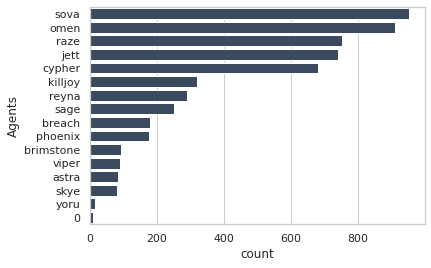

In [16]:
sns.countplot(y=base_geral['Agents'], order=base_geral['Agents'].value_counts(ascending=False).index, color='#364966')
#.value_counts().plot(kind='barh', ascending=False)

<AxesSubplot:xlabel='count', ylabel='Map'>

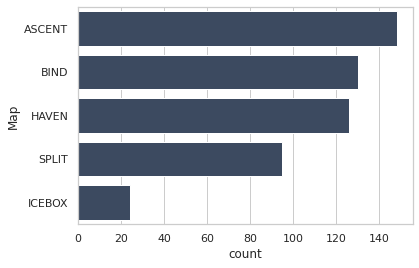

In [32]:
sns.countplot(y=base_agg['Map'], order=base_agg['Map'].value_counts(ascending=False).index, color='#364966')

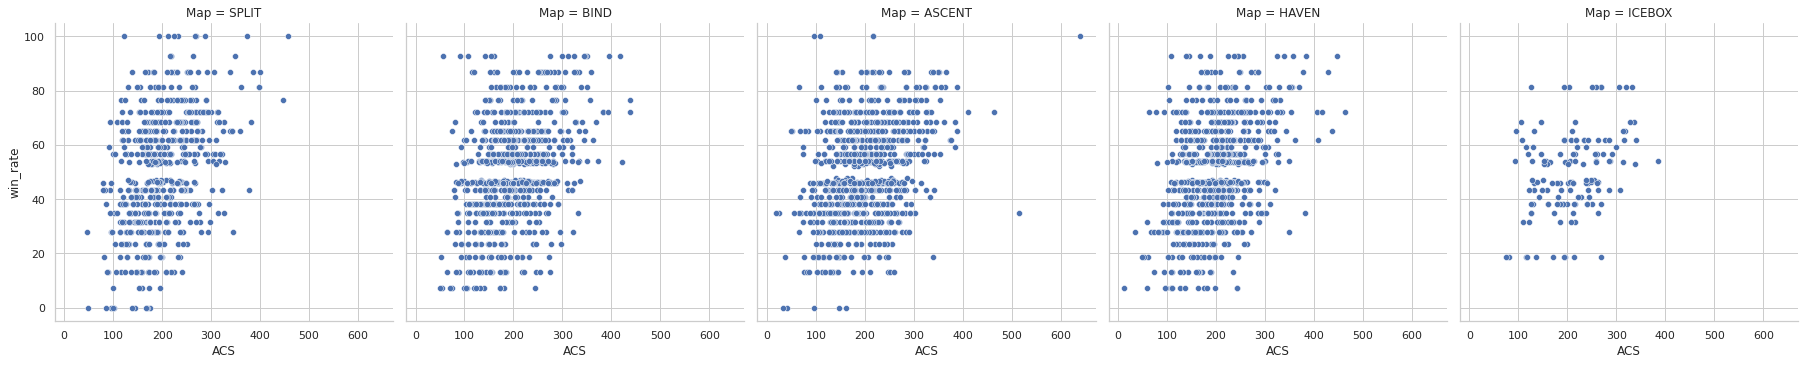

In [35]:
sns.relplot(
    data=base_geral, x='ACS', y='win_rate',
    col="Map",kind="scatter"
)

In [13]:
base_geral['class'] = ['duelist' if x in DUELIST 
                       else 'controller' if x in CONTROLLER
                       else 'initiator' if x in INITIATOR
                       else 'sentinel' for x in base_geral.Agents]

In [26]:
player_stats = ['Map', 'Agents','class', 'ACS', 'ADR', 'HS%', 'KPR', 'DPR', 'APR', 'FKPR', 'FDPR','FKWR', 'ECON', 'MKPR','CPR', 'K', 'D', 'A', 'KD_DIFF', '2K', '3K', '4K', '1v1','1v2','1v3','1v4','1v5', 'total_mult_kill', 'total_clutch']
team_stats = ['Map', 'rounds_won',	'rounds_lost','total_rounds',	'ct_rounds_won',	'ct_rounds_lost',	't_rounds_won',	't_rounds_lost', 'win_rate', 'ct_wr', 't_wr', 'Pistol_WR', 'Eco_0_5_WR' ,'Semi_Eco_5_10_WR' ,'Semi_Buy_10_20_WR', 'Full_Buy_20_WR']

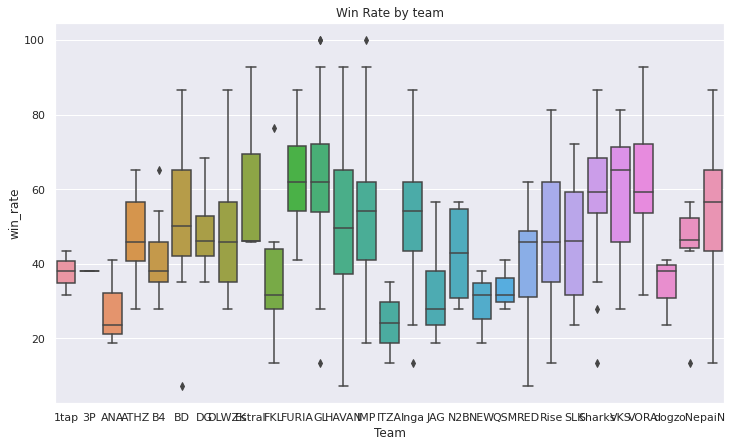

In [105]:
Boxplot(base_agg, 'Team', 'win_rate', title='Win Rate by team')

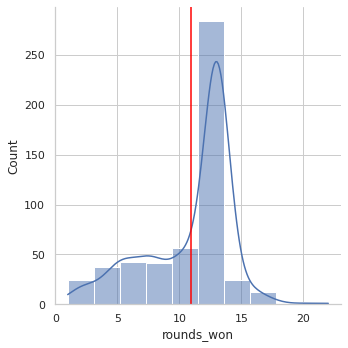

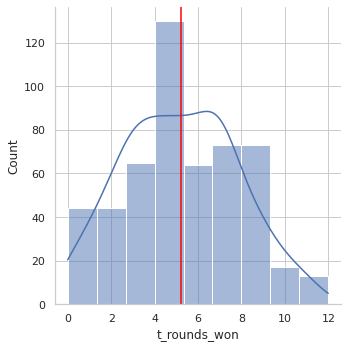

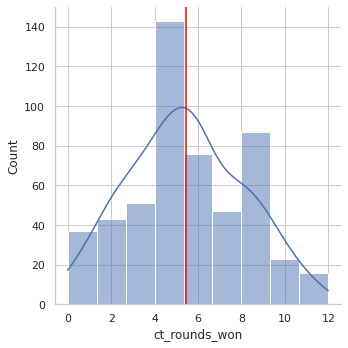

In [59]:
['rounds_won','t_rounds_won','ct_rounds_won']
['ACS', 'ADR', 'KPR']
for col in ['rounds_won','t_rounds_won','ct_rounds_won']:
    title = col + '_dist.png'
    bins =  1 + 3.322*np.log(base_agg[col].nunique())
    sns_plot = sns.displot(data=base_agg, x=col,
                            bins=int(bins), kde=True)
    plt.axvline(base_agg[col].mean(), 0,1, color='red')
    sns_plot.savefig(title)

ASCENT    742
BIND      654
HAVEN     630
SPLIT     475
ICEBOX    120
Name: Map, dtype: int64
SPLIT
Test Stat=0.967, p-value:0.000000
Sample does not look Gaussian (reject H0)
-----------------
BIND
Test Stat=0.984, p-value:0.000002
Sample does not look Gaussian (reject H0)
-----------------
ASCENT
Test Stat=0.974, p-value:0.000000
Sample does not look Gaussian (reject H0)
-----------------
HAVEN
Test Stat=0.977, p-value:0.000000
Sample does not look Gaussian (reject H0)
-----------------
ICEBOX
Test Stat=0.985, p-value:0.201079
Sample looks Gaussian (fail to reject H0)
-----------------
**********************
--Testes com 5 grupos--
--Estatística do teste = 2.189, p-valor = 0.7009565166
Não há evidências estatísticas significativas para concluir que existe diferença entre as medianas dos grupos


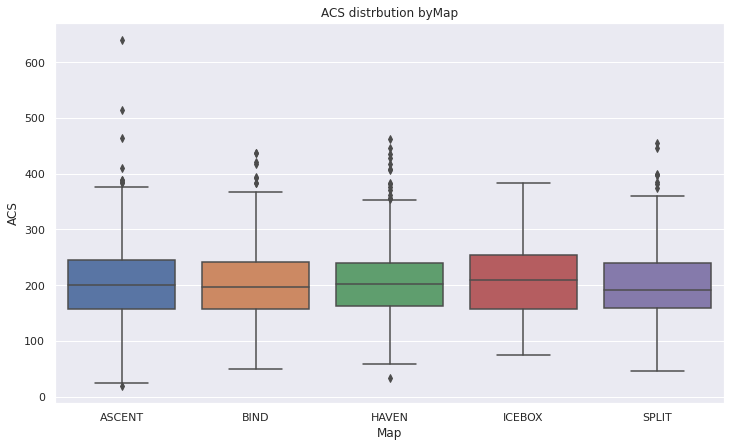

In [440]:
col = 'ACS'
name_col = 'Map'
Boxplot(base_geral, name_col, col, title= col + ' distrbution by' + name_col)
print(base_geral[name_col].value_counts())
for c in base_geral[name_col].unique():
    print(c)
    CheckGaussian(base_geral.loc[base_geral[name_col] == c, col])
    print('-----------------')
print('**********************')
KruskalWallis(base_geral, base_geral[name_col], col)

profile = ProfileReport(base_geral, title="Pandas Profiling Base Geral")
profile_agg = ProfileReport(base_agg, title="Pandas Profiling Base Agregada")
profile.to_file('report_base_geral.html')
profile_agg.to_file('report_base_agg.html')

## Comparing Teams x Rest on each map by given stat
stat = 'win_rate'
for mapa in base_geral.Map.unique():
    map_filter = FilterCol(base_geral, 'Map', [mapa])
    for time in base_geral.Team.unique():
        time_filter = FilterCol(map_filter, 'Team', [time])
        resto = map_filter.loc[map_filter['Team'] != time]
        media_time = round(time_filter[stat].mean(),2)
        media_resto = round(resto[stat].mean(),2)
        diff =  round(time_filter[stat].mean() / resto[stat].mean(), 3)
        print("MEAN "+ stat +" DIFF "+mapa+" -- "+time+" ("+str(media_time)+") X ("+str(media_resto)+") RESTO --> "+str(diff))

## PLAYER STAT DIFF FROM REST BY AGENT
stat = '1v1'
for boneco in base_geral.Agents.unique():
    aux = FilterCol(base_geral, 'Agents', [boneco])
    for jogador in aux.Player.unique():
        aux_jogador = FilterCol(aux, 'Player', [jogador])
        resto = aux.loc[aux['Player'] != jogador]
        media_jogador = round(aux_jogador[stat].mean(), 2)
        media_resto =  round(resto[stat].mean(),2)
        diff = round(media_jogador / media_resto, 2)
        print("MEAN "+ stat +" DIFF "+boneco+" -- "+jogador+" X RESTO: "+str(diff))

---
## Statistics

. D.E.S - Diferença estatisticamente signifcativa.

### Correlações
    - Target: WIN_RATE
    - Features: ACS, KPR, FKPR, ct_wr, t_wr, CLUTCHES PER ROUND, MK PER ROUND, <econ>_WR

### Hipoteses
    - SOBRE JOGADORES
        - Não há uma D.E.S entre a performance de diferentes agentes  em uma mesma categoria.
        - não há uma D.E.S entre a performance de diferentes jogadores de um mesmo agente
        - nao ha uma D.E.S entre agentes de uma mesma caterogira em termos de <STAT>
    - TIMES
        - 

In [132]:
base_geral.head()

Player  Agents  ACS   K   D  A  KD_DIFF    ADR  HS%  FK  FD  FK_FD_DIFF  \
0    Jonn    jett  398  22   9  5       13  224.6   18   3   1           2   
1  mwzera    raze  268  14  12  5        2  181.0   17   2   1           1   
2    JhoW    omen  185  13   8  7        5  103.9   19   1   1           0   
3   fznnn  cypher  155   8   9  9       -1   83.6   14   1   5          -4   
4   Nyang  breach  131   8  10  3       -2   66.6   15   0   1          -1   

   match_id Team_x Opp_Team_x  rounds_won  rounds_lost  ct_rounds_won  \
0      6797     GL        IMP          13            3             10   
1      6797     GL        IMP          13            3             10   
2      6797     GL        IMP          13            3             10   
3      6797     GL        IMP          13            3             10   
4      6797     GL        IMP          13            3             10   

   ct_rounds_lost  t_rounds_won  t_rounds_lost    Map  Patch_x  total_rounds  \
0               2             3              1  SPLIT     1.12            16   
1               2             3              1  SPLIT     1.12            16   
2               2             3              1  SPLIT     1.12            16   
3               2             3              1  SPLIT     1.12            16   
4               2             3              1  SPLIT     1.12            16   

   win_rate   KPR   DPR   APR  FKPR   FKWR  FDPR  ct_wr  t_wr RESULT  2K  3K  \
0     81.25  1.38  0.56  0.31  0.19  75.00  0.06  83.33  75.0      W   6   1   
1     81.25  0.88  0.75  0.31  0.12  66.67  0.06  83.33  75.0      W   3   1   
2     81.25  0.81  0.50  0.44  0.06  50.00  0.06  83.33  75.0      W   3   0   
3     81.25  0.50  0.56  0.56  0.06  16.67  0.31  83.33  75.0      W   3   0   
4     81.25  0.50  0.62  0.19  0.00   0.00  0.06  83.33  75.0      W   1   1   

    4K   5K  1v1  1v2  1v3  1v4  1v5  ECON  PL  DE Team_y Opp_Team_y  Patch_y  \
0  1.0  0.0  0.0  1.0  0.0  0.0  0.0   115   0   0     GL        IMP     1.12   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0    74   0   0     GL        IMP     1.12   
2  0.0  0.0  2.0  0.0  0.0  0.0  0.0    38   3   0     GL        IMP     1.12   
3  0.0  0.0  0.0  1.0  0.0  0.0  0.0    31   0   0     GL        IMP     1.12   
4  0.0  0.0  0.0  1.0  0.0  0.0  0.0    30   0   1     GL        IMP     1.12   

   total_mult_kill  total_clutch  MKPR   CPR  breach  brimstone  cypher  jett  \
0              8.0           1.0  0.50  0.06       0          0       0     1   
1              4.0           0.0  0.25  0.00       0          0       0     0   
2              3.0           2.0  0.19  0.12       0          0       0     0   
3              3.0           1.0  0.19  0.06       0          0       1     0   
4              2.0           1.0  0.12  0.06       1          0       0     0   

   killjoy  omen  phoenix  raze  reyna  sage  skye  sova  viper  yoru  \
0        0     0        0     0      0     0     0     0      0     0   
1        0     0        0     1      0     0     0     0      0     0   
2        0     1        0     0      0     0     0     0      0     0   
3        0     0        0     0      0     0     0     0      0     0   
4        0     0        0     0      0     0     0     0      0     0   

        class  
0     duelist  
1     duelist  
2  controller  
3    sentinel  
4   initiator


#ase_agg[AGENTS + ['win_rate']].corr(method='spearman')
for m in base_agg.Map.unique():
    print(m)
    print(round(base_agg.loc[base_agg.Map == m, AGENTS + ['win_rate']].corr(method='kendall')['win_rate'], 3))

In [124]:

#ase_agg[AGENTS + ['win_rate']].corr(method='spearman')
for m in base_agg.Map.unique():
    print(m)
    print(round(base_agg.loc[base_agg.Map == m, AGENTS + ['rounds_won']].corr(method='spearman')['rounds_won'], 3))

BIND
jett         -0.141
raze          0.124
phoenix      -0.162
reyna         0.281
yoru          0.051
omen          0.095
brimstone    -0.095
viper        -0.115
cypher        0.233
sage         -0.218
killjoy      -0.180
breach       -0.037
sova          0.102
skye            NaN
rounds_won    1.000
Name: rounds_won, dtype: float64
ASCENT
jett         -0.124
raze          0.055
phoenix      -0.161
reyna         0.093
yoru            NaN
omen          0.071
brimstone    -0.124
viper           NaN
cypher        0.114
sage          0.067
killjoy      -0.126
breach       -0.021
sova          0.077
skye            NaN
rounds_won    1.000
Name: rounds_won, dtype: float64
SPLIT
jett          0.107
raze          0.083
phoenix      -0.246
reyna        -0.164
yoru            NaN
omen          0.074
brimstone    -0.074
viper        -0.083
cypher        0.146
sage         -0.059
killjoy      -0.026
breach        0.068
sova          0.007
skye          0.077
rounds_won    1.000
Name: rounds_won

In [212]:
base_geral['RESULT_BIN'] = [1 if x == 'W' else 0 for x in base_geral['RESULT']]
base_agg['RESULT_BIN'] = [1 if x == 'W' else 0 for x in base_agg['RESULT']]
base_agg['RESULT_BIN'].value_counts()
#base_agg.loc[base_agg['RESULT'] == 'L', 'viper'].value_counts()
#base_agg.groupby('RESULT')['viper'].mean()

1    297
0    226
Name: RESULT_BIN, dtype: int64

In [ ]:
for a in AGENTS:
    if((base_agg.loc[base_agg['RESULT_BIN'] == 1, a].value_counts().nunique() == 2) & (base_agg.loc[base_agg['RESULT_BIN'] == 0, a].value_counts().nunique() == 2)):
        chi_a = base_agg.loc[base_agg['RESULT_BIN'] == 1, a].value_counts()
        chi_b = base_agg.loc[base_agg['RESULT_BIN'] == 0, a].value_counts()
        obs = np.array([chi_a, chi_b])
        print(base_geral.groupby(a)['RESULT_BIN'].mean())
        print(a)
        print(chi2_contingency(obs))
        #print(str(t) + ' --- '+ str(p))

In [233]:
for a in AGENTS:
    if(base_geral.loc[base_geral['RESULT_BIN'] == 1, a].value_counts().nunique() > 1):
        chi_a = base_geral.loc[base_geral['RESULT_BIN'] == 1, a].value_counts()
        chi_b = base_geral.loc[base_geral['RESULT_BIN'] == 0, a].value_counts()
        obs = np.array([chi_a, chi_b])
        print(a)
        print(base_geral.groupby(a)['RESULT_BIN'].mean())
        print(chi2_contingency(obs))
        #print(str(t) + ' --- '+ str(p))


jett
jett
0    0.502415
1    0.478632
Name: RESULT_BIN, dtype: float64
(0.8189910165333105, 0.36547533410538124, 1, array([[1446.4171123,  233.5828877],
       [1451.5828877,  234.4171123]]))
raze
raze
0    0.496217
1    0.517467
Name: RESULT_BIN, dtype: float64
(0.6322238162011873, 0.4265407750151272, 1, array([[1451.40819964,  228.59180036],
       [1456.59180036,  229.40819964]]))
phoenix
phoenix
0    0.500000
1    0.472222
Name: RESULT_BIN, dtype: float64
(0.22109393359445678, 0.6382076570649748, 1, array([[1626.09625668,   53.90374332],
       [1631.90374332,   54.09625668]]))
reyna
reyna
0    0.496090
1    0.556213
Name: RESULT_BIN, dtype: float64
(2.0866401146261477, 0.14859255524292972, 1, array([[1595.65062389,   84.34937611],
       [1601.34937611,   84.65062389]]))
yoru
yoru
0    0.499108
1    0.500000
Name: RESULT_BIN, dtype: float64
(0.49673802019136204, 0.480936925057734, 1, array([[1.67900178e+03, 9.98217469e-01],
       [1.68499822e+03, 1.00178253e+00]]))
omen
omen
0   

ACS  RESULT_BIN
ACS         1.000000    0.771207
RESULT_BIN  0.771207    1.000000

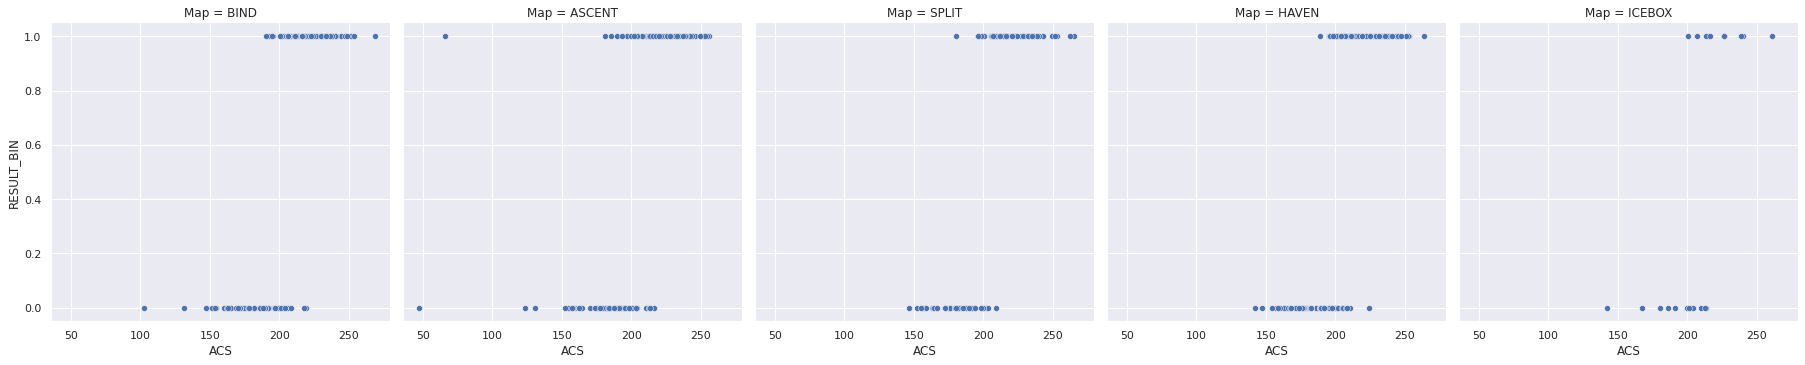

In [238]:
sns.relplot(
    data=base_agg, x='ACS', y='RESULT_BIN',
    col="Map", kind="scatter"
)
base_agg[['ACS', 'RESULT_BIN']].corr(method='spearman')

### Duelist

Test Stat=0.983, p-value:0.000000
Sample does not look Gaussian (reject H0)


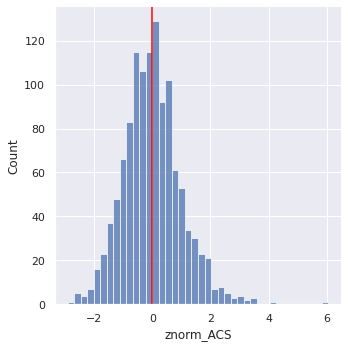

In [264]:
value_col = 'ACS'
norm_col = 'znorm_ACS'
target_col = 'win_rate'

duelist_df = FilterCol(base_geral, 'Agents', DUELIST)
duelist_df[norm_col] = duelist_df[value_col].transform(lambda x: zscore(x, ddof=1))
sns.displot(data=duelist_df, x=norm_col)
plt.axvline(duelist_df[norm_col].mean(), 0,1, color='red')
CheckGaussian(duelist_df[norm_col])

ACS x win_rate Corr @ SPLIT -- 0.571
ACS x win_rate Corr @ BIND -- 0.484
ACS x win_rate Corr @ ASCENT -- 0.44
ACS x win_rate Corr @ HAVEN -- 0.482
ACS x win_rate Corr @ ICEBOX -- 0.421


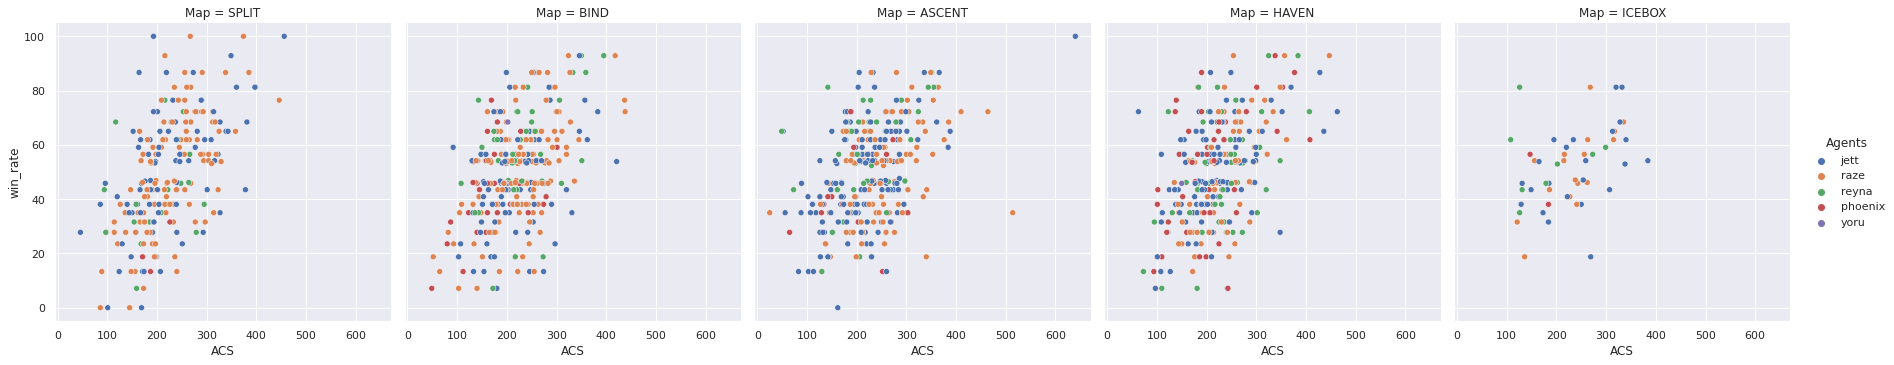

In [265]:
sns.relplot(
    data=duelist_df, x=value_col, y=target_col,
    col="Map", hue="Agents",kind="scatter"
)
for m in duelist_df.Map.unique():
    print(value_col + ' x '+ target_col +' Corr @ '+ m +' -- ' + str(round(duelist_df[duelist_df.Map == m].corr(method='pearson')[target_col][value_col], 3)))

jett       468
raze       458
reyna      169
phoenix    108
Name: Agents, dtype: int64
-----------------
--Testes com 4 grupos--
--Estatística do teste = 45.773, p-valor = 0.0000000006
Há evidências estatísticas significativas que indicam diferença entre as medianas dos grupos


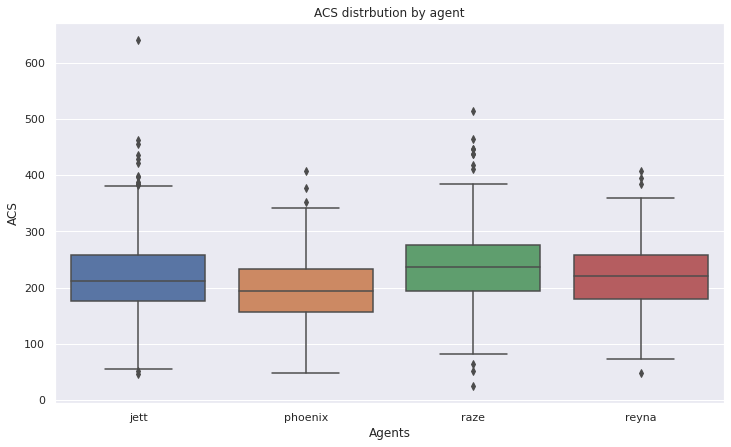

In [270]:
duelist_df = duelist_df[duelist_df['Agents'] != 'yoru']
Boxplot(duelist_df, 'Agents', value_col, title= value_col + ' distrbution by agent')
print(duelist_df['Agents'].value_counts())
print('-----------------')
KruskalWallis(duelist_df, duelist_df['Agents'], value_col)

          1             2         3             4         5
1  1.000000  7.079112e-05  0.877286  1.809886e-03  0.260294
2  0.000071  1.000000e+00  0.002198  1.502093e-08  0.123239
3  0.877286  2.198375e-03  1.000000  1.017000e-02  0.272069
4  0.001810  1.502093e-08  0.010170  1.000000e+00  0.544231
5  0.260294  1.232387e-01  0.272069  5.442312e-01  1.000000


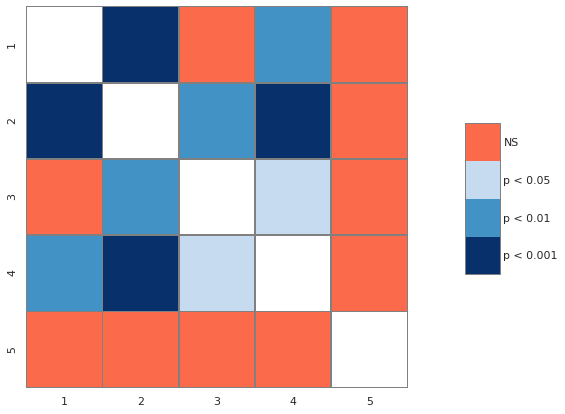

In [358]:
DunnPostHoc(duelist_df, duelist_df['Agents'], norm_col)

Test Stat=0.962, p-value:0.000000
Sample does not look Gaussian (reject H0)


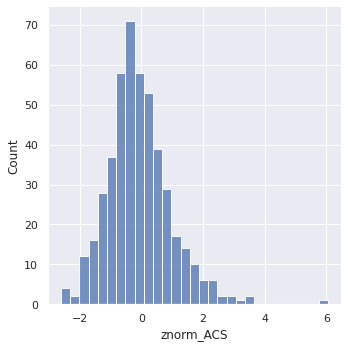

In [96]:
value_col = 'ACS'
norm_col = 'znorm_ACS'
target_col = 'win_rate'

jett_df = FilterCol(duelist_df, 'Agents', ['jett'])
sns.displot(data=jett_df, x=norm_col)
CheckGaussian(jett_df[norm_col])


ACS x win_rate Corr @ SPLIT -- 0.528
ACS x win_rate Corr @ BIND -- 0.361
ACS x win_rate Corr @ ASCENT -- 0.455
ACS x win_rate Corr @ HAVEN -- 0.458
ACS x win_rate Corr @ ICEBOX -- 0.531


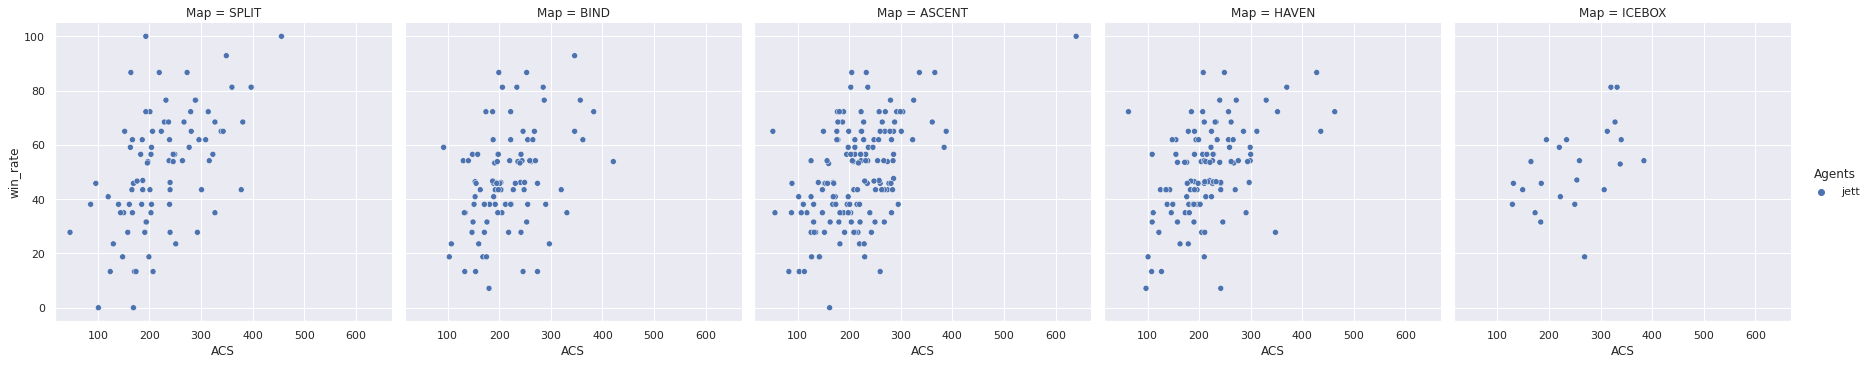

In [97]:
sns.relplot(
    data=jett_df, x=value_col, y=target_col,
    col="Map", hue="Agents",kind="scatter"
)
for m in jett_df.Map.unique():
    print(value_col + ' x '+ target_col +' Corr @ '+ m +' -- ' + str(round(jett_df[jett_df.Map == m].corr(method='spearman')[target_col][value_col], 3)))

ASCENT    151
HAVEN     111
BIND       96
SPLIT      87
ICEBOX     23
Name: Map, dtype: int64
-----------------
--Testes com 5 grupos--
--Estatística do teste = 4.239, p-valor = 0.3746617084
Não há evidências estatísticas significativas para concluir que existe diferença entre as medianas dos grupos


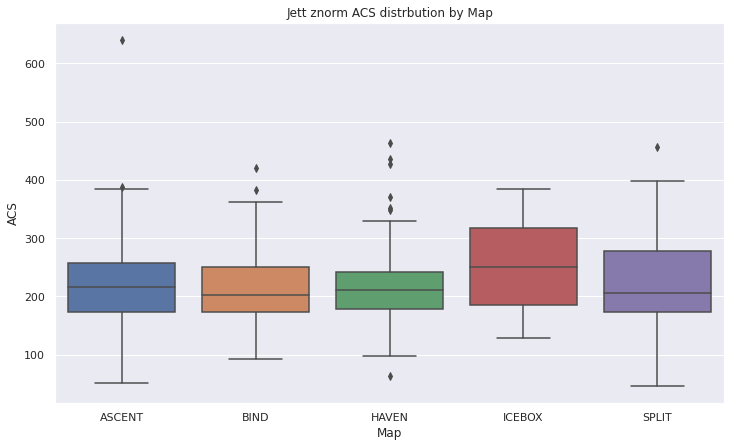

In [129]:
Boxplot(jett_df, 'Map', value_col, title='Jett znorm ACS distrbution by Map')
print(jett_df['Map'].value_counts())
print('-----------------')
KruskalWallis(jett_df, jett_df['Map'], norm_col)

Test Stat=0.984, p-value:0.000417
Sample does not look Gaussian (reject H0)


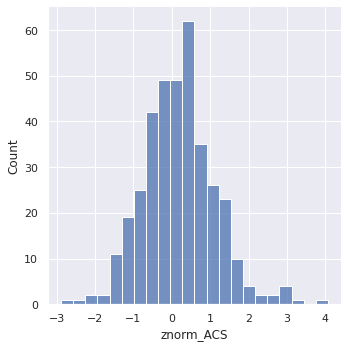

In [315]:
value_col = 'ACS'
norm_col = 'znorm_ACS'
target_col = 'win_rate'

raze_df = FilterCol(duelist_df, 'Agents', ['raze'])
sns.displot(data=raze_df, x=norm_col)
CheckGaussian(raze_df[norm_col])

ACS x win_rate Corr @ SPLIT -- 0.576
ACS x win_rate Corr @ BIND -- 0.447
ACS x win_rate Corr @ ASCENT -- 0.544
ACS x win_rate Corr @ HAVEN -- 0.558
ACS x win_rate Corr @ ICEBOX -- 0.812


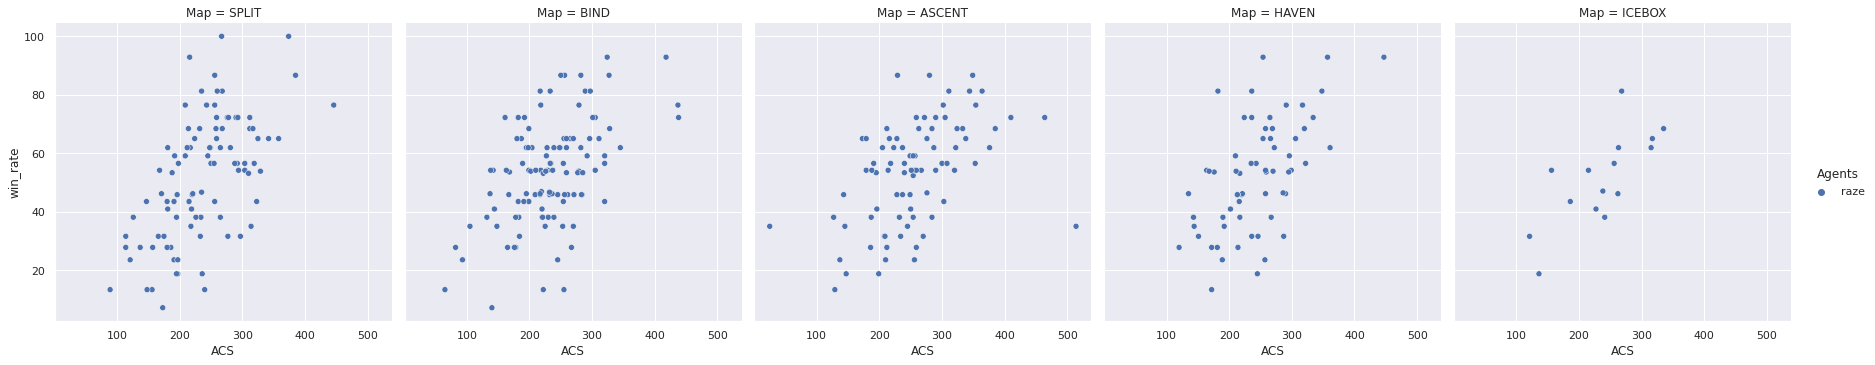

In [369]:
sns.relplot(
    data=raze_df, x=value_col, y=target_col,
    col="Map", hue="Agents",kind="scatter"
)
for m in raze_df.Map.unique():
    print(value_col + ' x '+ target_col +' Corr @ '+ m +' -- ' + str(round(raze_df[raze_df.Map == m].corr(method='spearman')[target_col][value_col], 3)))

BIND      116
SPLIT      94
ASCENT     83
HAVEN      63
ICEBOX     15
Name: Map, dtype: int64
-----------------
--Tetes com 5 grupos--
--Estatística do teste = 5.289, p-valor = 0.258940
Não há evidências estatísticas significativas para concluir que existe diferença entre as medianas dos grupos


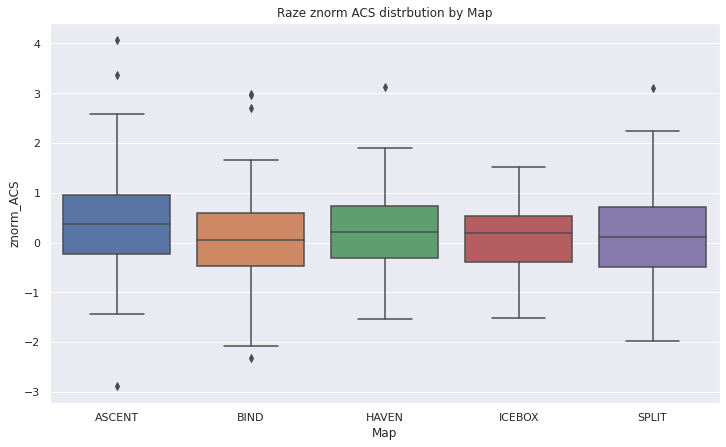

In [306]:
Boxplot(raze_df, 'Map', norm_col, title='Raze znorm ACS distrbution by Map')
print(raze_df['Map'].value_counts())
print('-----------------')
KruskalWallis(raze_df, raze_df['Map'], norm_col)

---
### Controller

Test Stat=0.990, p-value:0.000181
Sample does not look Gaussian (reject H0)


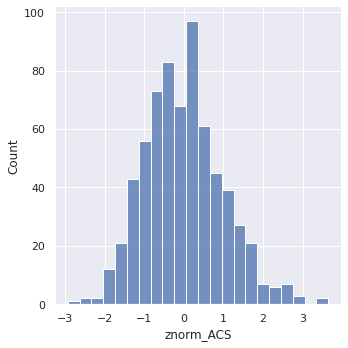

In [271]:
value_col = 'ACS'
norm_col = 'znorm_ACS'
target_col = 'win_rate'

controller_df = FilterCol(base_geral, 'Agents', CONTROLLER)
controller_df[norm_col] = controller_df[value_col].transform(lambda x: zscore(x, ddof=1))
sns.displot(data=controller_df, x=norm_col)
CheckGaussian(controller_df[norm_col])

ACS x win_rate Corr @ SPLIT -- 0.323
ACS x win_rate Corr @ BIND -- 0.413
ACS x win_rate Corr @ ASCENT -- 0.166
ACS x win_rate Corr @ HAVEN -- 0.406
ACS x win_rate Corr @ ICEBOX -- 0.252


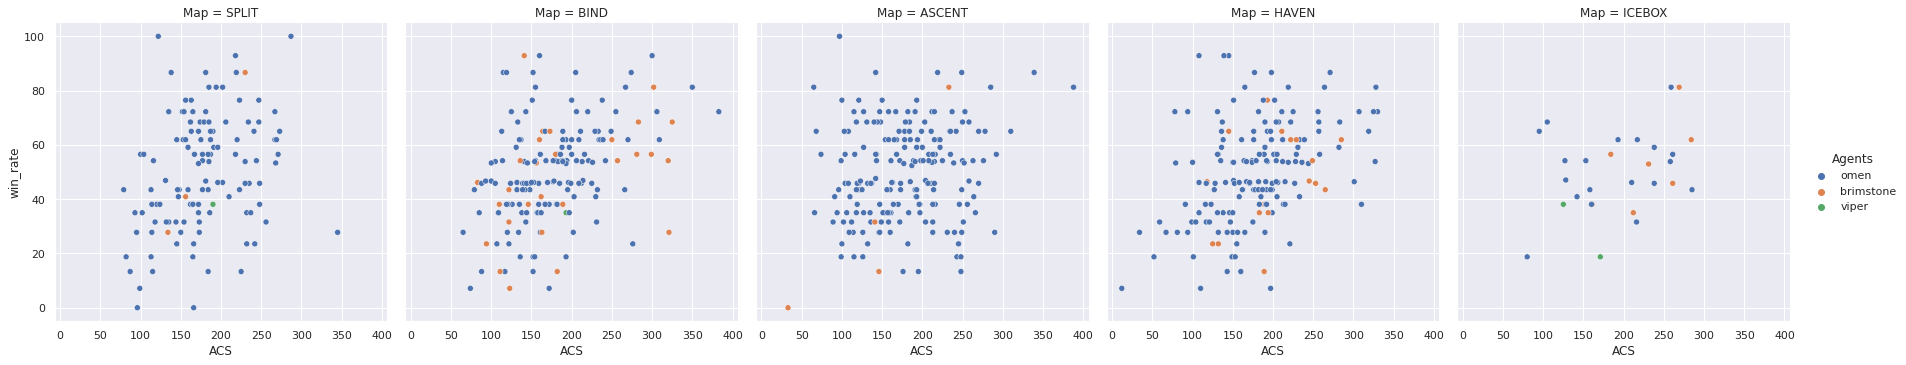

In [272]:
sns.relplot(
    data=controller_df, x=value_col, y=target_col,
    col="Map", hue="Agents",kind="scatter"
)
for m in controller_df.Map.unique():
    print(value_col + ' x '+ target_col +' Corr @ '+ m +' -- ' + str(round(controller_df[controller_df.Map == m].corr(method='spearman')[target_col][value_col], 3)))

omen         612
brimstone     60
Name: Agents, dtype: int64
-----------------
--Testes com 2 grupos--
--Estatística do teste = 2.948, p-valor = 0.0859700888
Não há evidências estatísticas significativas para concluir que existe diferença entre as medianas dos grupos


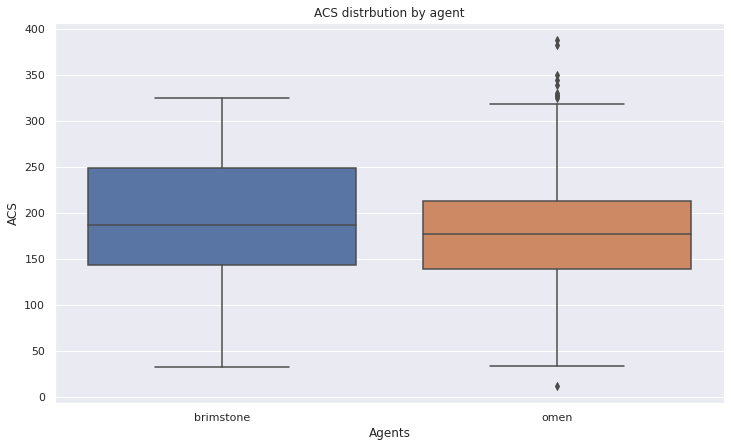

In [275]:
controller_df = controller_df[controller_df['Agents']!='viper']
Boxplot(controller_df, 'Agents', value_col, title='ACS distrbution by agent')
print(controller_df['Agents'].value_counts())
print('-----------------')
KruskalWallis(controller_df, controller_df['Agents'], value_col)

Test Stat=0.985, p-value:0.000074
Sample does not look Gaussian (reject H0)


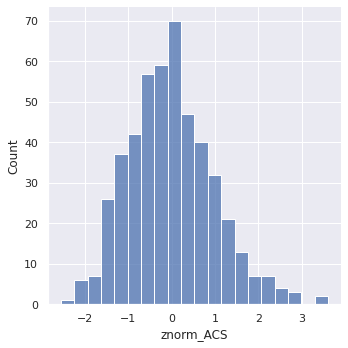

In [371]:
value_col = 'ACS'
norm_col = 'znorm_ACS'
target_col = 'win_rate'

omen_df = FilterCol(controller_df, 'Agents', ['omen'])
sns.displot(data=omen_df, x=norm_col)
CheckGaussian(omen_df[norm_col])

ACS x WIN RATE Corr @ SPLIT -- 0.285
ACS x WIN RATE Corr @ BIND -- 0.404
ACS x WIN RATE Corr @ ASCENT -- 0.117
ACS x WIN RATE Corr @ HAVEN -- 0.392
ACS x WIN RATE Corr @ ICEBOX -- -0.059


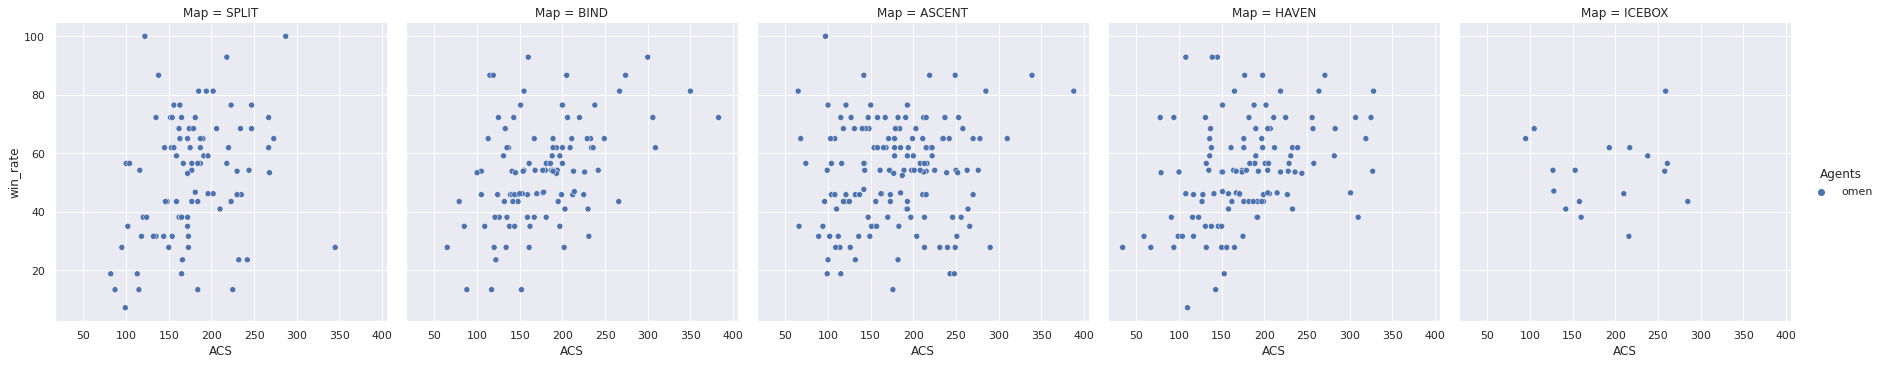

In [326]:
sns.relplot(
    data=omen_df, x=value_col, y=target_col,
    col="Map", hue="Agents",kind="scatter"
)
for m in omen_df.Map.unique():
    print(value_col + ' x '+ target_col +' Corr @ '+ m +' -- ' + str(round(omen_df[omen_df.Map == m].corr(method='spearman')[target_col][value_col], 3)))

ASCENT    146
HAVEN     119
BIND      107
SPLIT      92
ICEBOX     17
Name: Map, dtype: int64
-----------------
--Tetes com 5 grupos--
--Estatística do teste = 0.817, p-valor = 0.936114
Não há evidências estatísticas significativas para concluir que existe diferença entre as medianas dos grupos


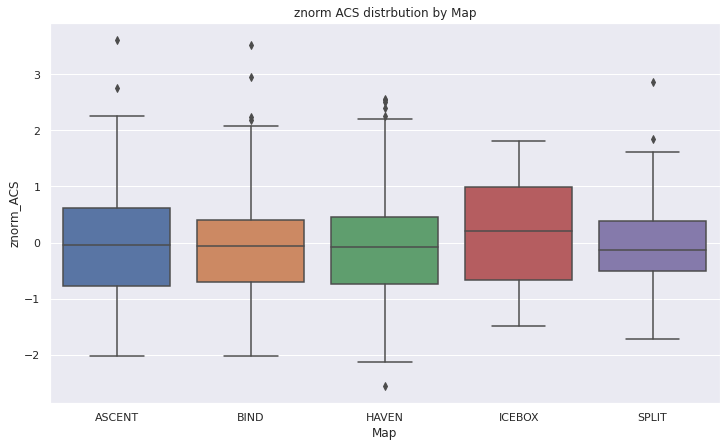

In [327]:
Boxplot(omen_df, 'Map', norm_col, title='znorm ACS distrbution by Map')
print(omen_df['Map'].value_counts())
print('-----------------')
KruskalWallis(omen_df, omen_df['Map'], norm_col)

### Initiators

Test Stat=0.991, p-value:0.000252
Sample does not look Gaussian (reject H0)


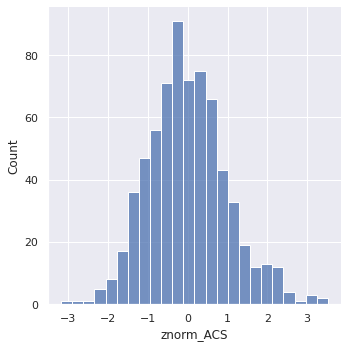

In [100]:
initiators_df = FilterCol(base_geral, 'Agents', INITIATOR)
initiators_df[norm_col] = initiators_df[value_col].transform(lambda x: zscore(x, ddof=1))
sns.displot(data=initiators_df, x=norm_col)
CheckGaussian(initiators_df[norm_col]) 

ACS x win_rate Corr @ SPLIT -- 0.279
ACS x win_rate Corr @ BIND -- 0.295
ACS x win_rate Corr @ ASCENT -- 0.425
ACS x win_rate Corr @ HAVEN -- 0.275
ACS x win_rate Corr @ ICEBOX -- 0.233


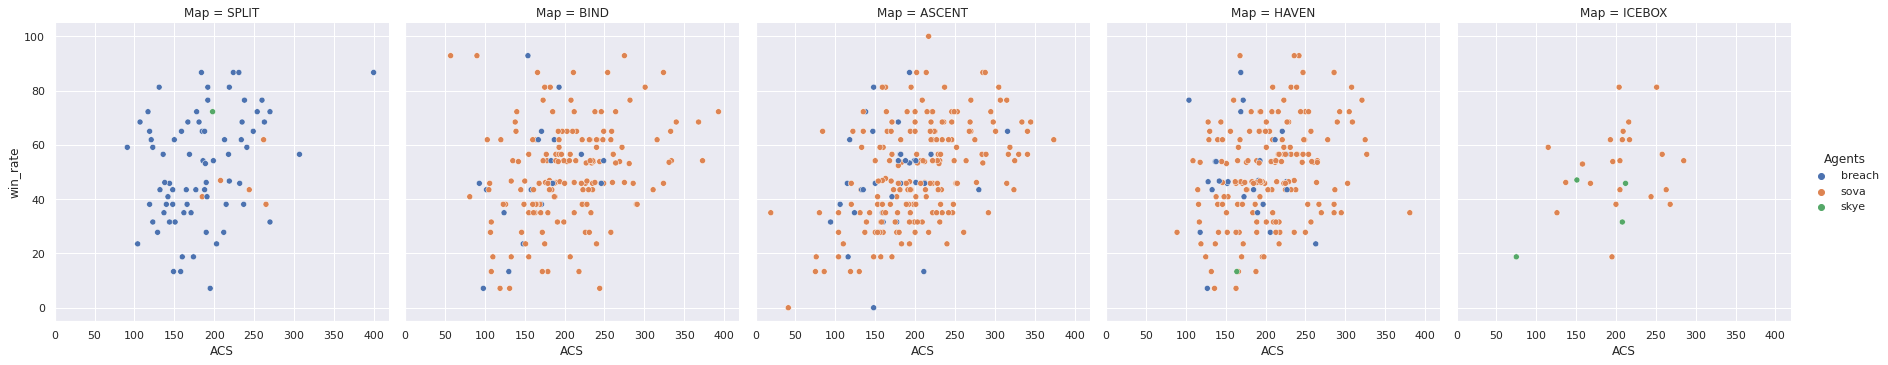

In [101]:
sns.relplot(
    data=initiators_df, x=value_col, y=target_col,
    col="Map", hue="Agents",kind="scatter"
)
for m in initiators_df.Map.unique():
    print(value_col + ' x '+ target_col +' Corr @ '+ m +' -- ' + str(round(initiators_df[initiators_df.Map == m].corr(method='spearman')[target_col][value_col], 3)))

sova      411
breach    105
skye        5
Name: Agents, dtype: int64
-----------------
--Tetes com 3 grupos--
--Estatística do teste = 32.329, p-valor = 0.000000
Há evidências estatísticas significativas que indicam diferença entre as medianas dos grupos


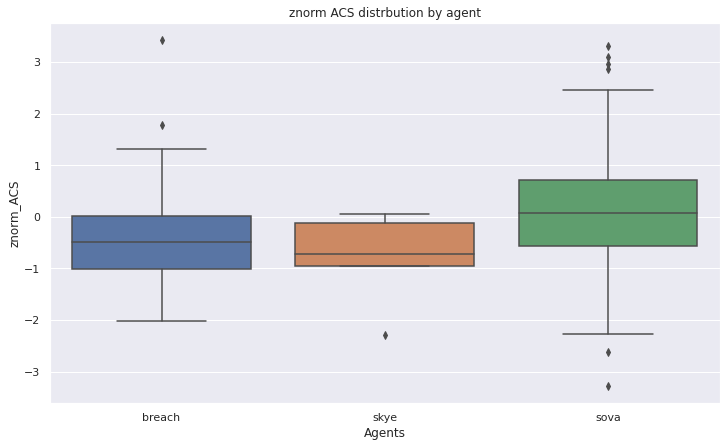

In [332]:
Boxplot(initiators_df, 'Agents',norm_col, title='znorm ACS distrbution by agent')
print(initiators_df['Agents'].value_counts())
print('-----------------')
KruskalWallis(initiators_df, initiators_df['Agents'], norm_col)

              1             2         3
1  1.000000e+00  5.725933e-08  0.527450
2  5.725933e-08  1.000000e+00  0.049778
3  5.274500e-01  4.977845e-02  1.000000


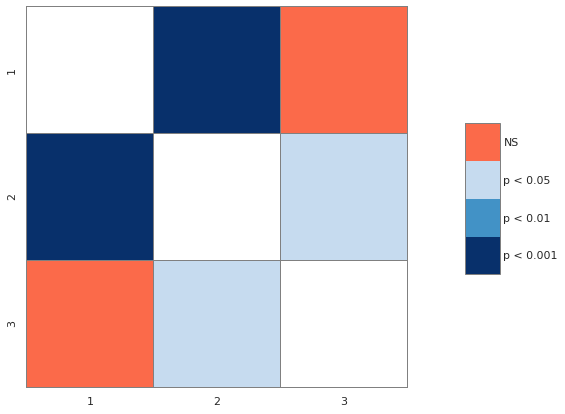

In [333]:
DunnPostHoc(initiators_df, initiators_df['Agents'], norm_col)

Test Stat=0.994, p-value:0.101053
Sample looks Gaussian (fail to reject H0)


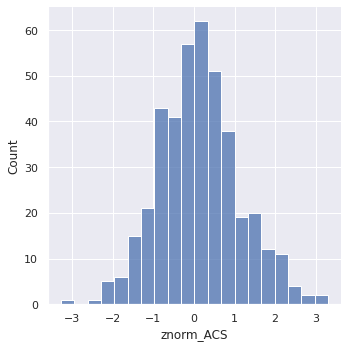

In [334]:
sova_df = FilterCol(initiators_df, 'Agents', ['sova'])
sns.displot(data=sova_df, x=norm_col)
CheckGaussian(sova_df[norm_col])

ACS x WIN RATE Corr @ BIND -- 0.275
ACS x WIN RATE Corr @ ASCENT -- 0.396
ACS x WIN RATE Corr @ HAVEN -- 0.248
ACS x WIN RATE Corr @ ICEBOX -- 0.151
ACS x WIN RATE Corr @ SPLIT -- 1.0


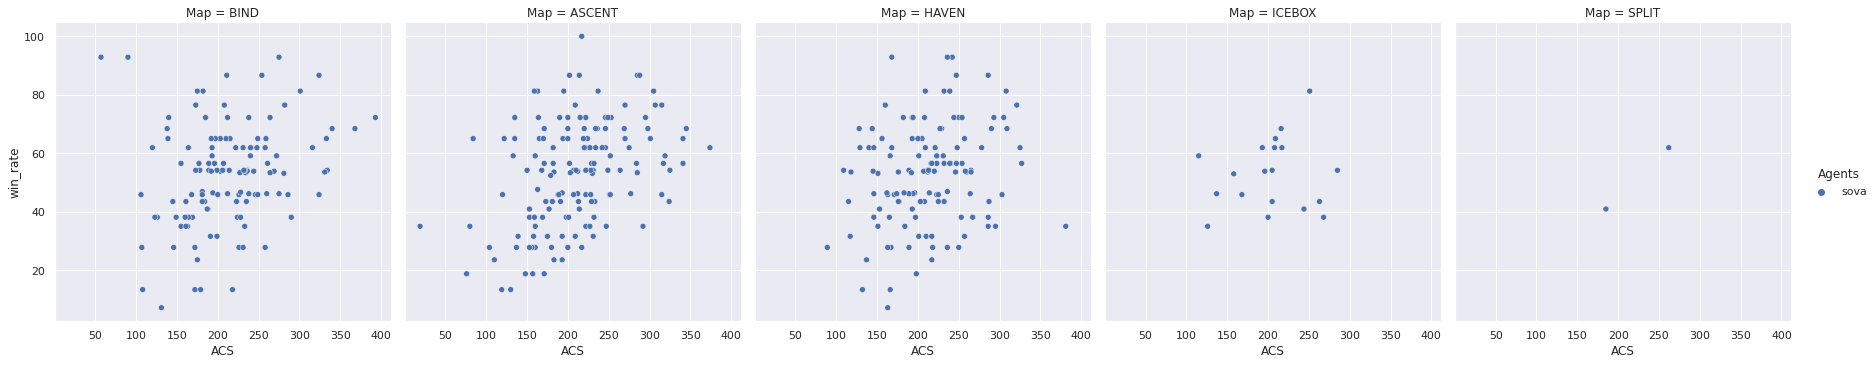

In [335]:
sns.relplot(
    data=sova_df, x=value_col, y=target_col,
    col="Map", hue="Agents", kind="scatter"
)
for m in sova_df.Map.unique():
    print(value_col + ' x '+ target_col +' Corr @ '+ m +' -- ' + str(round(sova_df[sova_df.Map == m].corr(method='spearman')[target_col][value_col], 3)))

ASCENT    145
HAVEN     125
BIND      120
ICEBOX     19
SPLIT       2
Name: Map, dtype: int64
-----------------
--Tetes com 5 grupos--
--Estatística do teste = 0.588, p-valor = 0.964364
Não há evidências estatísticas significativas para concluir que existe diferença entre as medianas dos grupos


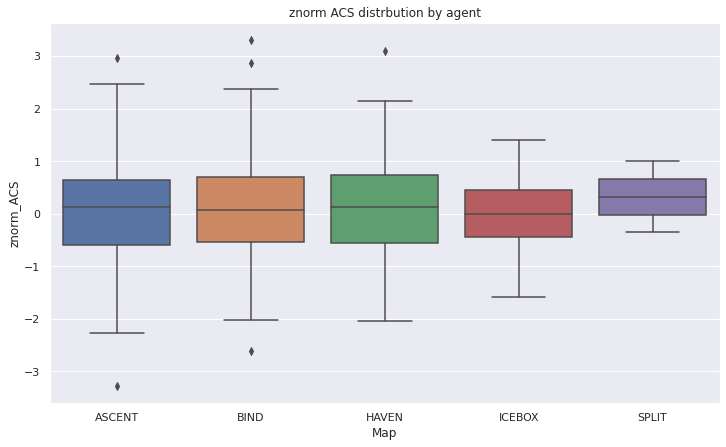

In [338]:
Boxplot(sova_df, 'Map', norm_col, title='znorm ACS distrbution by agent')
print(sova_df['Map'].value_counts())
print('-----------------')
KruskalWallis(sova_df, sova_df['Map'], norm_col)

### Sentinels

Test Stat=0.992, p-value:0.000328
Sample does not look Gaussian (reject H0)


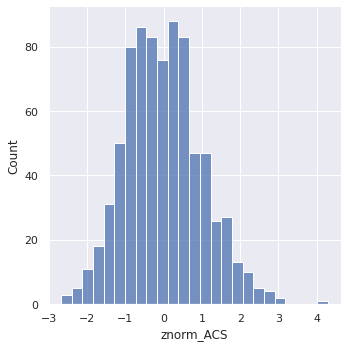

In [102]:
value_col = 'ACS'
norm_col = 'znorm_ACS'
target_col = 'win_rate'

sentinels_df = FilterCol(base_geral, 'Agents', SENTINEL)
sentinels_df[norm_col] = sentinels_df[value_col].transform(lambda x: zscore(x, ddof=1))
sns.displot(data=sentinels_df, x=norm_col)
CheckGaussian(sentinels_df[norm_col]) 

ACS x win_rate Corr @ SPLIT -- 0.349
ACS x win_rate Corr @ BIND -- 0.379
ACS x win_rate Corr @ ASCENT -- 0.289
ACS x win_rate Corr @ HAVEN -- 0.344
ACS x win_rate Corr @ ICEBOX -- 0.235


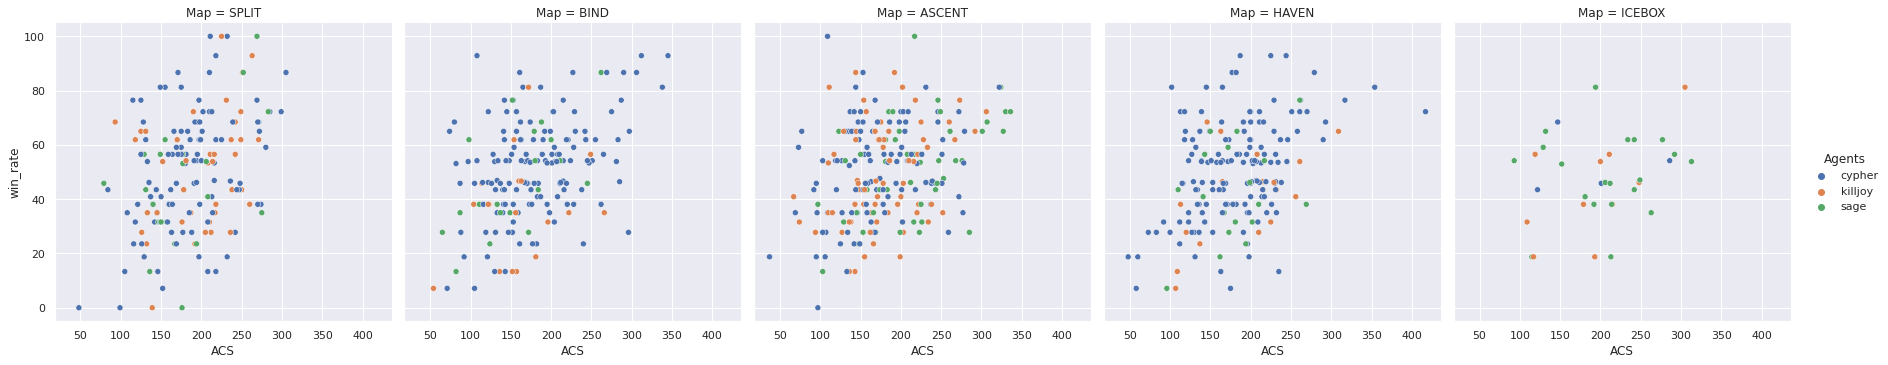

In [103]:
sns.relplot(
    data=sentinels_df, x=value_col, y=target_col,
    col="Map", hue="Agents",kind="scatter"
)
for m in sentinels_df.Map.unique():
    print(value_col + ' x '+ target_col +' Corr @ '+ m +' -- ' + str(round(sentinels_df[sentinels_df.Map == m].corr(method='spearman')[target_col][value_col], 3)))

cypher     410
killjoy    106
sage       104
Name: Agents, dtype: int64
-----------------
--Testes com 3 grupos--
--Estatística do teste = 6.190, p-valor = 0.0452799219
Há evidências estatísticas significativas que indicam diferença entre as medianas dos grupos


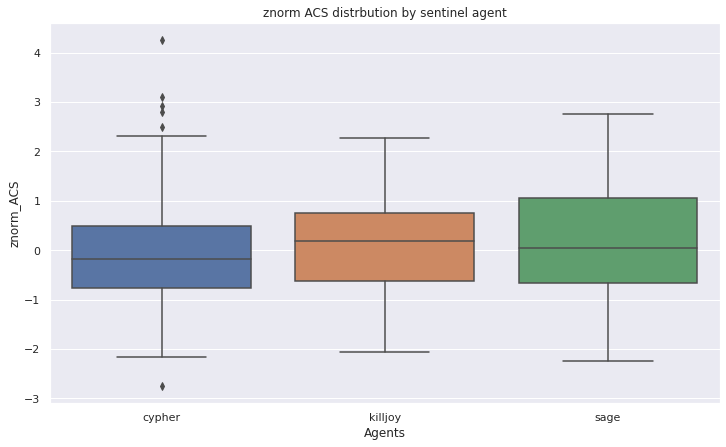

In [469]:
Boxplot(sentinels_df, 'Agents', norm_col, title='znorm ACS distrbution by sentinel agent')
print(sentinels_df['Agents'].value_counts())
print('-----------------')
KruskalWallis(sentinels_df, sentinels_df['Agents'], norm_col)

          1         2         3
1  1.000000  0.087157  0.034229
2  0.087157  1.000000  0.738482
3  0.034229  0.738482  1.000000


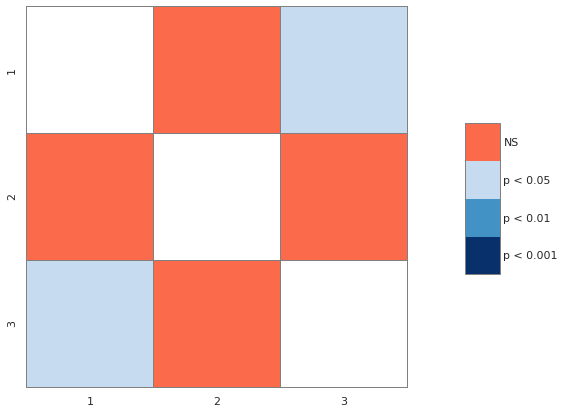

In [343]:
DunnPostHoc(sentinels_df, sentinels_df['Agents'], norm_col)

Test Stat=0.983, p-value:0.000117
Sample does not look Gaussian (reject H0)


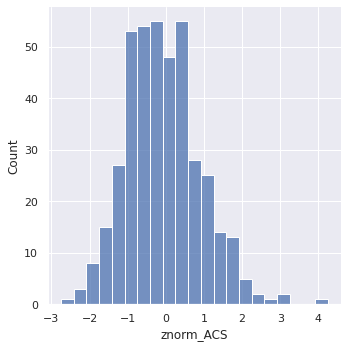

In [345]:
value_col = 'ACS'
norm_col = 'znorm_ACS'
target_col = 'win_rate'

cypher_df = FilterCol(sentinels_df, 'Agents', ['cypher'])
sns.displot(data=cypher_df, x=norm_col)
CheckGaussian(cypher_df[norm_col])

ACS x win_rate Corr @ SPLIT -- 0.272
ACS x win_rate Corr @ BIND -- 0.275
ACS x win_rate Corr @ ASCENT -- 0.205
ACS x win_rate Corr @ HAVEN -- 0.319
ACS x win_rate Corr @ ICEBOX -- 0.5


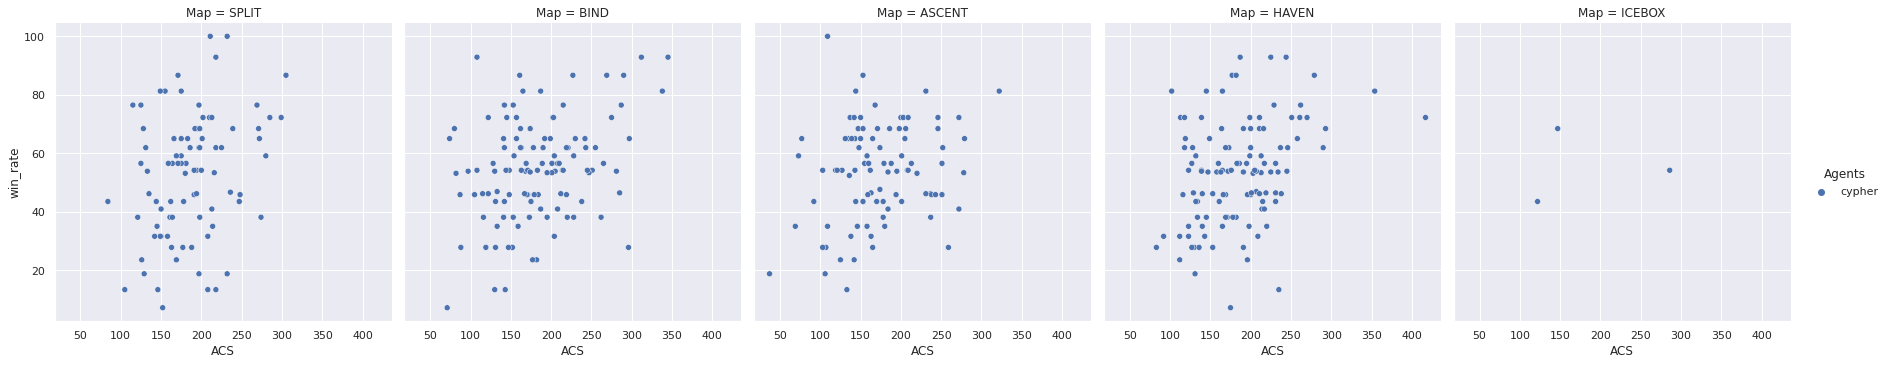

In [373]:
sns.relplot(
    data=cypher_df, x=value_col, y=target_col,
    col="Map", hue="Agents",kind="scatter"
)
for m in cypher_df.Map.unique():
    print(value_col + ' x '+ target_col +' Corr @ '+ m +' -- ' + str(round(cypher_df[cypher_df.Map == m].corr(method='spearman')[target_col][value_col], 3)))

HAVEN     115
BIND      113
ASCENT     92
SPLIT      87
ICEBOX      3
Name: Map, dtype: int64
-----------------
--Tetes com 5 grupos--
--Estatística do teste = 4.555, p-valor = 0.336041
Não há evidências estatísticas significativas para concluir que existe diferença entre as medianas dos grupos


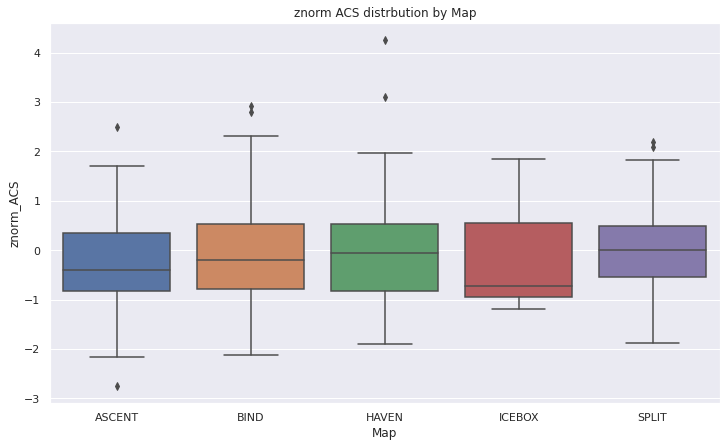

In [347]:
Boxplot(cypher_df, 'Map', norm_col, title='znorm ACS distrbution by Map')
print(cypher_df['Map'].value_counts())
print('-----------------')
KruskalWallis(cypher_df, cypher_df['Map'], norm_col)

---
### Quantiles by <feature> x ACS

In [184]:
for a in base_geral.Agents.unique():
    df = base_geral[base_geral.Agents == a]
    #qs = QuantileCut(df, 'ACS', 'win_rate', quantis=6)
    print(a)
    KruskalWallis(df, df['Map'], 'ACS')

jett
--Testes com 5 grupos--
--Estatística do teste = 4.239, p-valor = 0.3746617084
Não há evidências estatísticas significativas para concluir que existe diferença entre as medianas dos grupos
raze
--Testes com 5 grupos--
--Estatística do teste = 10.766, p-valor = 0.0293210967
Há evidências estatísticas significativas que indicam diferença entre as medianas dos grupos
omen
--Testes com 5 grupos--
--Estatística do teste = 1.442, p-valor = 0.8367846875
Não há evidências estatísticas significativas para concluir que existe diferença entre as medianas dos grupos
cypher
--Testes com 5 grupos--
--Estatística do teste = 5.420, p-valor = 0.2468837484
Não há evidências estatísticas significativas para concluir que existe diferença entre as medianas dos grupos
breach
--Testes com 4 grupos--
--Estatística do teste = 2.382, p-valor = 0.4970309239
Não há evidências estatísticas significativas para concluir que existe diferença entre as medianas dos grupos
killjoy
--Testes com 5 grupos--
--Estatíst

In [76]:
#ACS, KPR DPR	APR	FKPR FDPR, ct_wr, t_wr, CLUTCHES PER ROUND (CPR), MK PER ROUND(MKPR), Pistol_WR	Eco_0_5_WR	Semi_Eco_5_10_WR  Semi_Buy_10_20_WR	 Full_Buy_20_WR
#stats_cols = ['ACS', 'KPR', 'DPR', 'APR', 'FKPR', 'FDPR']
#perf_cols = ['CPR', 'MKPR', 'ct_wr', 't_wr']
#econ_cols = ['Pistol_WR', 'Eco_0_5_WR','Semi_Eco_5_10_WR' ,'Semi_Buy_10_20_WR', "Full_Buy_20_WR"]
#(base_agg, nome_col='KPR', value_col='win_rate')
def CorrMatrixWinRate(df, cols):
    cols = cols + ['win_rate']
    corr_spearman = round(df[cols].corr(method='pearson'),3)
    mask = np.zeros_like(corr_spearman)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr_spearman,  fmt="f", vmin=0, vmax=1, mask=mask, annot=True)

In [249]:
player_stats = ['ACS', 'ADR', 'KPR', 'FKPR','FDPR', 'MKPR', 'CPR']
team_stats = ['ct_wr', 't_wr', 'Pistol_WR', 'Eco_0_5_WR' ,'Semi_Eco_5_10_WR' ,'Semi_Buy_10_20_WR', 'Full_Buy_20_WR']

In [250]:
base_agg.head()

Team_x  match_id     Map     ACS      K      D     A  KD_DIFF     ADR  \
0   1tap      4797    BIND  175.29  12.00  15.29  2.86    -3.29  117.14   
1   1tap      5174  ASCENT  200.57  12.57  16.14  2.57    -3.57  121.74   
2   1tap      5174    BIND  173.14  14.14  16.57  5.29    -2.43  110.77   
3     3P      8238  ASCENT  188.20  13.40  16.40  4.00    -3.00  111.30   
4    ANA      2717   SPLIT  172.60  10.00  14.60  3.20    -4.60   98.82   

     HS%   ECON  FK  FD   KPR   DPR   APR  FKPR  FDPR  2K  3K   4K   5K  1v1  \
0  18.00  48.14  13  20  3.99  5.08  0.96  0.62  0.97  14   5  1.0  0.0  1.0   
1  26.43  48.43   9  18  4.63  5.93  0.95  0.48  0.94  20   4  0.0  0.0  2.0   
2  23.14  48.86  12  18  4.31  5.05  1.61  0.52  0.78  19   4  0.0  0.0  0.0   
3  17.80  45.60   6  15  3.18  3.90  0.96  0.29  0.72  12   4  0.0  1.0  0.0   
4  21.00  40.20   7  10  2.94  4.28  0.95  0.42  0.59   9   2  0.0  0.0  1.0   

   1v2  1v3  1v4  1v5  PL  DE  total_mult_kill  MKPR  total_clutch   CPR  \
0  0.0  0.0  0.0  0.0   4   0             20.0  0.95           1.0  0.05   
1  0.0  0.0  0.0  0.0   6   2             24.0  1.26           2.0  0.10   
2  0.0  0.0  0.0  0.0   8   5             23.0  0.98           0.0  0.00   
3  1.0  0.0  1.0  0.0   6   1             17.0  0.83           2.0  0.10   
4  0.0  0.0  0.0  0.0   3   2             11.0  0.65           1.0  0.06   

   jett  raze  phoenix  reyna  yoru  omen  brimstone  viper  cypher  sage  \
0     2     0        1      0     0     1          0      0       0     0   
1     2     0        0      1     0     1          0      0       0     0   
2     2     0        1      0     0     1          0      0       0     2   
3     1     1        1      0     0     1          0      0       0     0   
4     1     1        0      1     0     1          0      0       1     0   

   killjoy  breach  sova  skye Opp_Team_x  rounds_won  rounds_lost  \
0        2       0     1     0       paiN           8           13   
1        2       0     1     0       paiN           6           13   
2        0       0     1     0       paiN          10           13   
3        0       0     1     0         BD           8           13   
4        0       0     0     0         FF           4           13   

   ct_rounds_won  ct_rounds_lost  t_rounds_won  t_rounds_lost  Patch_x  \
0              4               5             4              8     1.10   
1              5               7             1              6     1.10   
2              7               5             3              8     1.10   
3              3               6             5              7     1.14   
4              2              10             2              3     1.07   

   total_rounds  win_rate  ct_wr   t_wr RESULT  Team  Pistol_W  Pistol_P  \
0            21     38.10  44.44  33.33      L  1tap         0         2   
1            19     31.58  41.67  14.29      L  1tap         1         2   
2            23     43.48  58.33  27.27      L  1tap         1         2   
3            21     38.10  33.33  41.67      L    3P         1         2   
4            17     23.53  16.67  40.00      L   ANA         1         2   

   Pistol_WR  Eco_0_5_P  Eco_0_5_W  Eco_0_5_WR  Semi_Eco_5_10_P  \
0        0.0          4          0         0.0                1   
1       50.0          3          1        33.0                3   
2       50.0          3          1        33.0                1   
3       50.0          2          1        50.0                2   
4       50.0          4          1        25.0                0   

   Semi_Eco_5_10_W  Semi_Eco_5_10_WR  Semi_Buy_10_20_P  Semi_Buy_10_20_W  \
0                0               0.0                 2                 2   
1                1              33.0                 5                 1   
2                1             100.0                 4                 1   
3                2             100.0                 8                 2   
4                0               0.0        

In [262]:
round(base_agg[team_stats + ['win_rate']].corr(method='pearson'), 2)

ct_wr  t_wr  Pistol_WR  Eco_0_5_WR  Semi_Eco_5_10_WR  \
ct_wr               1.00  0.21       0.36        0.43              0.01   
t_wr                0.21  1.00       0.37        0.37              0.04   
Pistol_WR           0.36  0.37       1.00        0.92              0.03   
Eco_0_5_WR          0.43  0.37       0.92        1.00              0.03   
Semi_Eco_5_10_WR    0.01  0.04       0.03        0.03              1.00   
Semi_Buy_10_20_WR   0.42  0.53       0.24        0.27             -0.04   
Full_Buy_20_WR      0.64  0.62       0.15        0.17             -0.04   
win_rate            0.75  0.76       0.45        0.49              0.04   

                   Semi_Buy_10_20_WR  Full_Buy_20_WR  win_rate  
ct_wr                           0.42            0.64      0.75  
t_wr                            0.53            0.62      0.76  
Pistol_WR                       0.24            0.15      0.45  
Eco_0_5_WR                      0.27            0.17      0.49  
Semi_Eco_5_10_WR               -0.04           -0.04      0.04  
Semi_Buy_10_20_WR               1.00            0.33      0.61  
Full_Buy_20_WR                  0.33            1.00      0.86  
win_rate                        0.61            0.86      1.00

<AxesSubplot:>

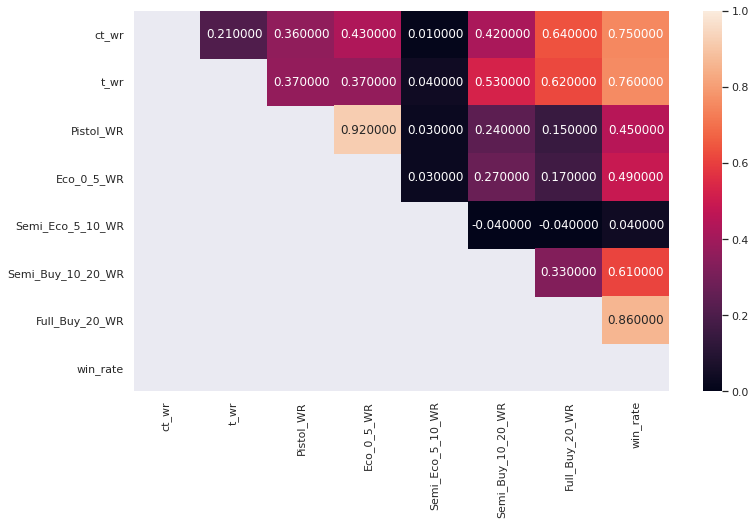

In [263]:
corr_spearman = round(base_agg[team_stats + ['win_rate']].corr(method='pearson'), 2)
mask = np.zeros_like(corr_spearman)
mask[np.tril_indices_from(mask)] = True
sns.heatmap(corr_spearman,  fmt="f", vmin=0, vmax=1, mask=mask, annot=True)

<AxesSubplot:>

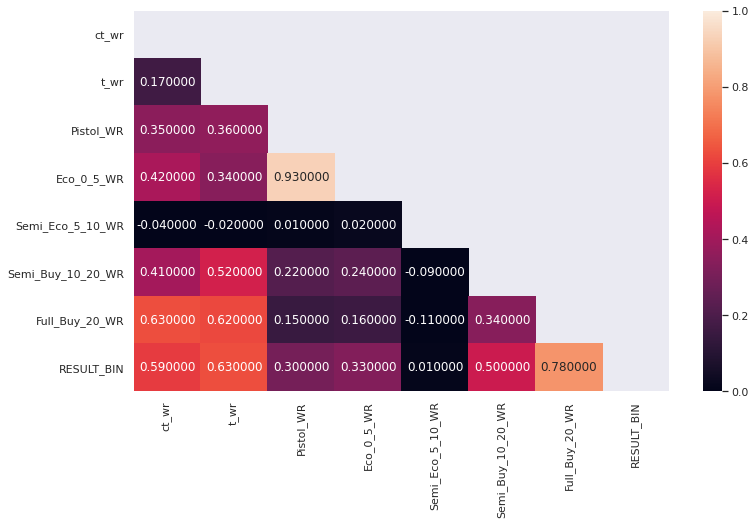

In [241]:
corr_spearman = round(base_agg[team_stats + ['RESULT_BIN']].corr(method='spearman'), 2)
mask = np.zeros_like(corr_spearman)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_spearman,  fmt="f", vmin=0, vmax=1, mask=mask, annot=True)
#mask = np.zeros_like(corr)
#mask[np.triu_indices_from(mask)] = True
#sns.heatmap(corr,  fmt="f", vmin=0, vmax=1, mask=mask, annot=False)

In [240]:
round(base_agg[team_stats + ['RESULT_BIN']].corr(method='pearson'), 2)

ct_wr  t_wr  Pistol_WR  Eco_0_5_WR  Semi_Eco_5_10_WR  \
ct_wr               1.00  0.21       0.36        0.43              0.01   
t_wr                0.21  1.00       0.37        0.37              0.04   
Pistol_WR           0.36  0.37       1.00        0.92              0.03   
Eco_0_5_WR          0.43  0.37       0.92        1.00              0.03   
Semi_Eco_5_10_WR    0.01  0.04       0.03        0.03              1.00   
Semi_Buy_10_20_WR   0.42  0.53       0.24        0.27             -0.04   
Full_Buy_20_WR      0.64  0.62       0.15        0.17             -0.04   
RESULT_BIN          0.58  0.62       0.31        0.34              0.07   

                   Semi_Buy_10_20_WR  Full_Buy_20_WR  RESULT_BIN  
ct_wr                           0.42            0.64        0.58  
t_wr                            0.53            0.62        0.62  
Pistol_WR                       0.24            0.15        0.31  
Eco_0_5_WR                      0.27            0.17        0.34  
Semi_Eco_5_10_WR               -0.04           -0.04        0.07  
Semi_Buy_10_20_WR               1.00            0.33        0.48  
Full_Buy_20_WR                  0.33            1.00        0.74  
RESULT_BIN                      0.48            0.74        1.00

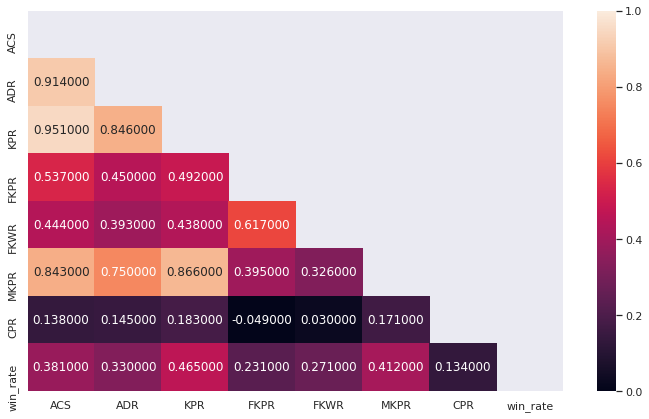

In [88]:
CorrMatrixWinRate(base_geral, player_stats)

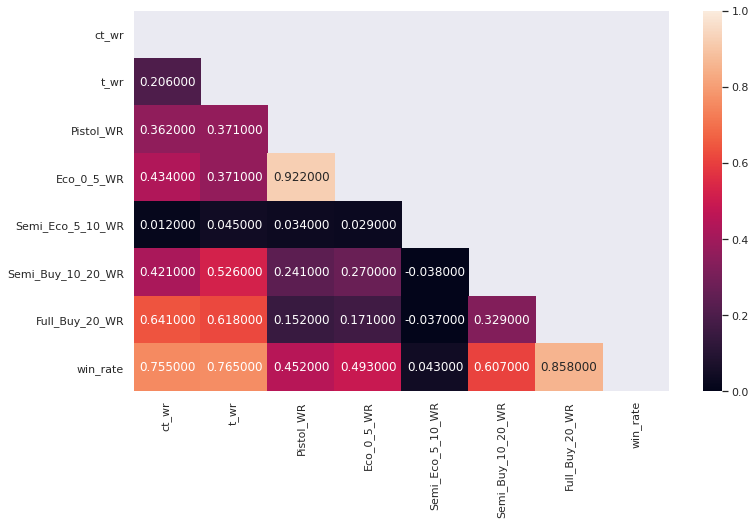

In [93]:
CorrMatrixWinRate(base_agg, team_stats)

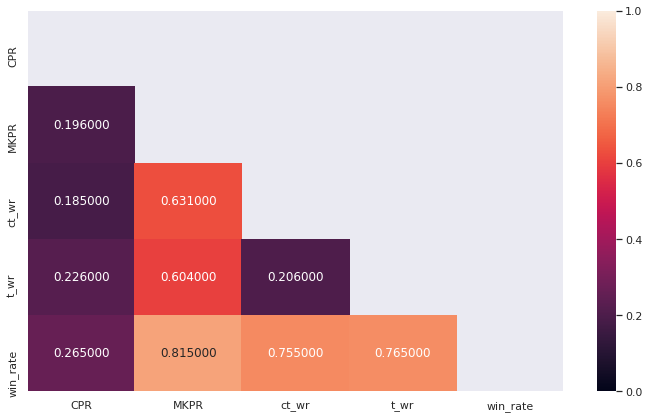

In [464]:
CorrMatrixWinRate(base_agg, perf_cols)

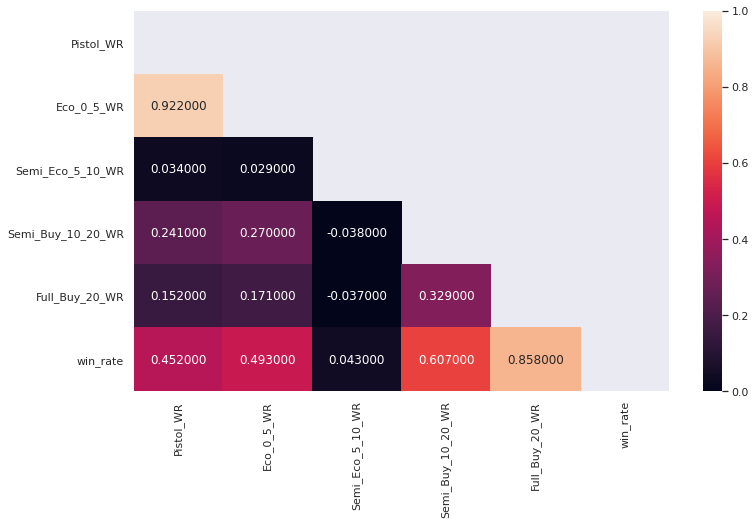

In [465]:
CorrMatrixWinRate(base_agg, econ_cols)